In [ ]:
# Attack-chain detection: Initial Access -> Exfiltration/Impact
import os, pandas as pd, networkx as nx

OUT_ATTACK_CSV = r'e:/Knowledge Graph/attack_chains.csv'
OUT_ATTACK_HTML = r'e:/Knowledge Graph/attack_chain_samples.html'
MERGED = r'e:/Knowledge Graph/final_kg_merged.csv'
ACTOR_PATTERNS = ['APT','FIN','CARBANAK','OILRIG','SANDWORM','WIZARDSPIDER']

# Load merged KG if available, else attempt to use in-memory `combined` or `df_kg`
if os.path.exists(MERGED):
    df = pd.read_csv(MERGED)
    print('Loaded merged KG:', MERGED)
else:
    if 'combined' in globals():
        df = combined.copy()
        print('Using in-memory `combined` DataFrame')
    elif 'df_kg' in globals():
        df = df_kg.copy()
        print('Using in-memory `df_kg`')
    else:
        raise RuntimeError('No merged KG or df_kg found — run earlier cells first')

# Normalize node labels for matching
def norm(s):
    return '' if pd.isna(s) else ' '.join(str(s).split()).upper()

df['h_n'] = df['head'].apply(norm)
df['t_n'] = df['tail'].apply(norm)
df['r_n'] = df['relation'].astype(str).apply(lambda x: str(x).upper())

# Build directed graph
G_ac = nx.DiGraph()
for _, r in df.iterrows():
    h, t = r['h_n'], r['t_n']
    if not h or not t:
        continue
    rel = r['r_n']
    G_ac.add_node(h)
    G_ac.add_node(t)
    # allow multiple relation tags on same edge
    if G_ac.has_edge(h,t):
        s = G_ac[h][t].get('rels', set())
        s.add(rel)
        G_ac[h][t]['rels'] = s
    else:
        G_ac.add_edge(h,t, rels=set([rel]))

print('Attack-chain graph: nodes=', G_ac.number_of_nodes(), 'edges=', G_ac.number_of_edges())

# Identify start (Initial Access) and end (Exfiltration/Impact) tactic nodes
starts = [n for n in G_ac.nodes() if 'INITIAL ACCESS' in n or 'INITIAL_ACCESS' in n or 'INITIAL' in n]
ends = [n for n in G_ac.nodes() if 'EXFILTRATION' in n or 'IMPACT' in n]
# Fallback: include known tactic names if present in node labels
if not starts:
    possible = ['INITIAL ACCESS','INITIAL_ACCESS','INITIAL']
    starts = [n for n in G_ac.nodes() if any(p in n for p in possible)]
if not ends:
    possible_e = ['EXFILTRATION','IMPACT']
    ends = [n for n in G_ac.nodes() if any(p in n for p in possible_e)]

print('Start tactic nodes found:', len(starts), 'End tactic nodes found:', len(ends))

# Collect simple directed paths from each start to each end (limit length to avoid explosion)
MAX_LEN = 6
paths = []
for s in starts:
    for e in ends:
        if s == e:
            continue
        try:
            for p in nx.all_simple_paths(G_ac, source=s, target=e, cutoff=MAX_LEN):
                # record actors seen on this path
                actors_on_path = [n for n in p if any(a in n for a in ACTOR_PATTERNS)]
                paths.append({'path': ' -> '.join(p), 'length': len(p)-1, 'actors': ';'.join(sorted(set(actors_on_path))), 'num_actors': len(set(actors_on_path))})
        except nx.NetworkXNoPath:
            continue

df_attack = pd.DataFrame(paths).sort_values(['num_actors','length'], ascending=[False, True])
if not df_attack.empty:
    df_attack.to_csv(OUT_ATTACK_CSV, index=False)
    print('Saved detected attack chains to', OUT_ATTACK_CSV, 'count=', len(df_attack))
    print('
Top sample attack chains:')
    print(df_attack.head(10).to_string(index=False))
else:
    print('No attack chains found with current graph and cutoff.')

# Create a small PyVis HTML for the top N paths (first 5) to visually inspect chains
try:
    from pyvis.network import Network
    topN = df_attack.head(5)
    if not topN.empty:
        net = Network(directed=True, height='600px', width='100%', notebook=True)
        nodes_added = set()
        for _, r in topN.iterrows():
            nodes = [n.strip() for n in r['path'].split('->')]
            for i in range(len(nodes)-1):
                a = nodes[i]; b = nodes[i+1]
                if a not in nodes_added:
                    net.add_node(a, label=a)
                    nodes_added.add(a)
                if b not in nodes_added:
                    net.add_node(b, label=b)
                    nodes_added.add(b)
                net.add_edge(a, b)
        net.show(OUT_ATTACK_HTML)
        print('Saved sample attack-chain visualization to', OUT_ATTACK_HTML)
except Exception as e:
    print('Could not create HTML visualization:', e)

In [ ]:
# Step 3 (new): Robust, resumable loop over CTI descriptions to extract LLM triples
# - Uses existing `extract_triples_from_text()` and writes incremental CSV with `entry_key` for resume.
import os, csv, time, json
from tqdm import tqdm

# Configuration: change MAX_ENTRIES for quick tests (set to None to run all)
MAX_ENTRIES = 10  # set to None to run entire dataset; change after test
OUT_FULL = r'e:/Knowledge Graph/llm_extracted_triples_full.csv'
SAVE_EVERY = 20  # flush to disk every N processed entries

# Load already-processed entry keys if present (we use file::#index as entry_key)
processed_entry_keys = set()
if os.path.exists(OUT_FULL):
    try:
        import pandas as _pd
        _df_prev = _pd.read_csv(OUT_FULL)
        if 'entry_key' in _df_prev.columns:
            processed_entry_keys.update(_df_prev['entry_key'].astype(str).tolist())
        print(f'Loaded {len(processed_entry_keys)} already-processed entry keys from {OUT_FULL}')
    except Exception as e:
        print('Failed to read existing output for resume:', e)

# Helper to build text from entry (same logic as earlier cell)
def entry_text_for_extraction(entry):
    parts = []
    for k in ['DESCRIPTION','DESCRIPTION_TEXT','NOTES','context','note']:
        val = None
        if isinstance(entry, dict):
            val = entry.get(k) or entry.get(k.lower())
        if val:
            parts.append(str(val))
    return '\n'.join(parts).strip()

# Iterate files and entries, extract, and save incrementally
colnames = ['head','relation','tail','source','source_file','raw_response','entry_key']
buffer = []
processed_count = 0
for fp in files:
    try:
        with open(fp, 'r', encoding='utf-8') as fh:
            j = json.load(fh)
    except Exception as e:
        print(f'Cannot load {fp}: {e}')
        continue

    for idx, entry in enumerate(j):
        entry_key = f'{fp}::#{idx}'
        if entry_key in processed_entry_keys:
            continue

        text = entry_text_for_extraction(entry)
        if not text:
            # nothing to extract
            processed_entry_keys.add(entry_key)
            continue

        try:
            parsed_triples, raw = extract_triples_from_text(text)
        except Exception as e:
            print(f'LLM failed for {fp}#{idx}: {e}')
            # do not crash; skip this entry (can retry later)
            continue

        for t in parsed_triples:
            t['source_file'] = fp
            t['source'] = 'LLM_Extraction'
            t['raw_response'] = raw
            t['entry_key'] = entry_key
            buffer.append({k: t.get(k, '') for k in colnames})

        # mark entry processed (even if zero triples were produced) to avoid re-processing
        processed_entry_keys.add(entry_key)
        processed_count += 1

        # Periodic flush to disk
        if processed_count % SAVE_EVERY == 0:
            mode = 'a' if os.path.exists(OUT_FULL) else 'w'
            try:
                with open(OUT_FULL, mode, newline='', encoding='utf-8') as outf:
                    writer = csv.DictWriter(outf, fieldnames=colnames)
                    if mode == 'w':
                        writer.writeheader()
                    for r in buffer:
                        writer.writerow(r)
                buffer = []
                print(f'Flushed progress to {OUT_FULL} (processed entries: {processed_count})')
            except Exception as e:
                print('Failed to flush progress:', e)

        # Respect a MAX_ENTRIES test limit (None = run all)
        if MAX_ENTRIES and processed_count >= MAX_ENTRIES:
            break
    if MAX_ENTRIES and processed_count >= MAX_ENTRIES:
        break

# Final flush of remaining buffer
if buffer:
    mode = 'a' if os.path.exists(OUT_FULL) else 'w'
    try:
        with open(OUT_FULL, mode, newline='', encoding='utf-8') as outf:
            writer = csv.DictWriter(outf, fieldnames=colnames)
            if mode == 'w':
                writer.writeheader()
            for r in buffer:
                writer.writerow(r)
        print(f'Final flush complete: {OUT_FULL}')
    except Exception as e:
        print('Final flush failed:', e)

print(f'Done. Total processed entries: {processed_count} | Saved to: {OUT_FULL}')

In [ ]:
# Step 4: Merge pre-labeled CTI triples (`df_kg`) with LLM-extracted triples
# - Normalizes head/relation/tail, prioritizes CTI labels over LLM when duplicates exist,
#   deduplicates, saves merged KG CSV, rebuilds graph and updates metrics + PyVis.
import os, pandas as pd, networkx as nx
from pyvis.network import Network

OUT_MERGED = r'e:/Knowledge Graph/final_kg_merged.csv'
OUT_HTML = r'e:/Knowledge Graph/enhanced_cti_kg_with_llm.html'
OUT_METRICS = r'e:/Knowledge Graph/graph_metrics_all_techniques_merged.csv'
ALLOWED_RELATIONS = ['USES','BELONGS_TO','UTILIZES','EMPLOYS','TARGETS','C2_OF','COMMUNICATES_WITH','EXPLOITS']

# Load CTI-provided triples (in-memory `df_kg` preferred)
if 'df_kg' in globals():
    df_cti = df_kg.copy()
    print('Using in-memory `df_kg` with', len(df_cti), 'rows')
else:
    # try to find an exported CSV if present
    fallback_cti = r'e:/Knowledge Graph/df_kg.csv'
    if os.path.exists(fallback_cti):
        df_cti = pd.read_csv(fallback_cti)
        print('Loaded CTI triples from', fallback_cti)
    else:
        raise RuntimeError('No `df_kg` in memory and no fallback CTI CSV found. Run the triple-mapping cell first.')

# Load LLM triples (prefer the full-run file, else fall back to sample)
llm_full = r'e:/Knowledge Graph/llm_extracted_triples_full.csv'
llm_sample = r'e:/Knowledge Graph/llm_extracted_triples_sample.csv'
if os.path.exists(llm_full):
    df_llm = pd.read_csv(llm_full)
    print('Loaded LLM triples from', llm_full)
elif os.path.exists(llm_sample):
    df_llm = pd.read_csv(llm_sample)
    print('Loaded LLM triples from sample:', llm_sample)
else:
    df_llm = pd.DataFrame(columns=['head','relation','tail','source','source_file','raw_response','entry_key'])
    print('No LLM triples file found; proceeding with CTI-only.')

# Normalize function: strip, collapse whitespace, and uppercase (safe for CTI labels and CVEs)
def norm_text(x):
    if pd.isna(x):
        return ''
    s = str(x).strip()
    s = ' '.join(s.split())
    return s.upper()

for df, name in [(df_cti, 'CTI'), (df_llm, 'LLM')]:
    for col in ['head','relation','tail']:
        if col in df.columns:
            df[col] = df[col].astype(str).fillna('').apply(norm_text)

# Filter LLM relations to allowed set (if relation column exists)
if 'relation' in df_llm.columns:
    df_llm = df_llm[df_llm['relation'].astype(str).str.upper().isin(ALLOWED_RELATIONS)].copy()

# Ensure 'source' column exists and label CTI rows as 'CTI'
df_cti['source'] = df_cti.get('source', 'CTI')
df_llm['source'] = df_llm.get('source', 'LLM_Extraction')

# Select canonical columns if extra fields exist
df_cti_c = df_cti[['head','relation','tail','source']].copy()
if 'context' in df_cti.columns:
    df_cti_c['context'] = df_cti['context'].astype(str).fillna('')

df_llm_c = df_llm[['head','relation','tail','source']].copy() if not df_llm.empty else df_llm.copy()

# Concatenate and deduplicate, preferring CTI rows over LLM when identical triple exists
combined = pd.concat([df_cti_c, df_llm_c], ignore_index=True, sort=False)
# Mark priority: CTI rows first so drop_duplicates keeps them
priority_map = {'CTI': 0, 'LLM_Extraction': 1, 'LLM':1}
combined['priority'] = combined['source'].map(lambda s: priority_map.get(s, 2))
combined = combined.sort_values('priority')
combined = combined.drop_duplicates(subset=['head','relation','tail'], keep='first').reset_index(drop=True)
combined.drop(columns=['priority'], inplace=True)

# Save merged KG CSV
combined.to_csv(OUT_MERGED, index=False)
print(f'Merged KG saved to: {OUT_MERGED} (rows: {len(combined)})')

# Rebuild NetworkX graph and save interactive PyVis HTML
G_merged = nx.DiGraph()
for _, r in combined.iterrows():
    h, rel, t = r['head'], r['relation'], r['tail']
    G_merged.add_node(h, title=h)
    G_merged.add_node(t, title=t)
    G_merged.add_edge(h, t, relation=rel, source=r.get('source',''))

net = Network(directed=True, height='750px', width='100%', notebook=True)
net.from_nx(G_merged)
# color nodes by whether they appear in CTI vs only LLM (if available)
for n in net.nodes:
    nid = n['id']
    # if node appears as head/tail in CTI, mark red; else orange if only LLM
    in_cti = ((df_cti_c['head'] == nid) | (df_cti_c['tail'] == nid)).any()
    n['color'] = '#FF6B6B' if in_cti else '#FFA500'
    n['size'] = 20

net.show(OUT_HTML)
print('Interactive merged KG saved to:', OUT_HTML)

# Recompute simple metrics (degree, betweenness, actor coverage) and save
degree = dict(G_merged.degree())
betw = nx.betweenness_centrality(G_merged)
# derive actor patterns from earlier cell heuristics
actor_patterns = ['APT','FIN','CARBANAK','OILRIG','SANDWORM','WIZARDSPIDER']
actors = [n for n in G_merged.nodes() if any(p in n.upper() for p in actor_patterns)]
techniques = [n for n in G_merged.nodes() if n not in actors]
metrics = []
for t in techniques:
    connected_actors = set()
    for u,v in G_merged.in_edges(t):
        if u in actors:
            connected_actors.add(u)
    for u,v in G_merged.out_edges(t):
        if v in actors:
            connected_actors.add(v)
    metrics.append({'node': t, 'num_actors': len(connected_actors), 'actors': ';'.join(sorted(list(connected_actors))), 'degree': degree.get(t,0), 'betweenness': betw.get(t,0.0)})

pd.DataFrame(metrics).sort_values(['num_actors','degree'], ascending=False).to_csv(OUT_METRICS, index=False)
print('Saved merged metrics to:', OUT_METRICS)

In [8]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import json
import requests
import os

# Install pyvis for interactive visualization (optional but recommended)
!pip install pyvis
from pyvis.network import Network


[notice] A new release of pip is available: 25.2 -> 26.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [1]:
# Clone the repository to get the dataset
!git clone https://github.com/dessertlab/CTI-HAL.git


Cloning into 'CTI-HAL'...
Updating files:  94% (303/319)
Updating files:  95% (304/319)
Updating files:  96% (307/319)
Updating files:  97% (310/319)
Updating files:  98% (313/319)
Updating files:  99% (316/319)
Updating files: 100% (319/319)
Updating files: 100% (319/319), done.


In [6]:
# Path to the standardized JSON files
data_path = 'e:\\Knowledge Graph\\CTI-HAL\\data'

In [22]:
print(f"Data path: {data_path}")
print(f"Exists: {os.path.exists(data_path)}")
if os.path.exists(data_path):
    print(f"Contents: {os.listdir(data_path)}")

Data path: e:\Knowledge Graph\CTI-HAL\data
Exists: True
Contents: ['apt29', 'carbanak', 'fin6', 'fin7', 'oilrig', 'sandworm', 'wizardspider']


In [9]:
# Recursively find all .json files in the CTI-HAL directory and its subdirectories
files = []
for root, dirs, filenames in os.walk(data_path):
    for filename in filenames:
        if filename.endswith('.json'):
            files.append(os.path.join(root, filename))

print(f"Found {len(files)} CTI reports.")

Found 81 CTI reports.


In [10]:
"""
Triple Mapping Logic:
- Actor (APT/Group) USES Technique
- Technique BELONGS_TO Tactic
- Technique UTILIZES Tool
- Context provides additional information about usage scenarios
"""

triples = []

for file_path in files:
    with open(file_path, 'r') as f:
        data = json.load(f)
        
        # Extract actor name from file path (e.g., 'apt29', 'carbanak', etc.)
        # Format: e:\Knowledge Graph\CTI-HAL\data\{actor}\{annotator}\{report}.json
        path_parts = file_path.split(os.sep)
        actor_name = path_parts[-3].upper()  # Get the actor directory name
        
        for entry in data:
            metadata = entry.get('metadata', {})
            context = entry.get('context', 'Unknown')
            
            # Extract tactics
            tactic_names = metadata.get('tactic_name', [])
            tactics = metadata.get('tactic', [])
            
            # Extract techniques
            technique_name = metadata.get('technique_name')
            technique = metadata.get('technique')
            
            # Extract tools
            tool_names = metadata.get('tool_name', [])
            tools = metadata.get('tool', [])
            
            # Triple 1: Actor USES Technique
            if technique_name and actor_name:
                triples.append({
                    'head': actor_name,
                    'relation': 'USES',
                    'tail': technique_name,
                    'context': context
                })
            
            # Triple 2: Technique BELONGS_TO Tactic
            if technique_name and tactic_names:
                for tactic_name in tactic_names:
                    if tactic_name:
                        triples.append({
                            'head': technique_name,
                            'relation': 'BELONGS_TO',
                            'tail': tactic_name,
                            'context': context
                        })
            
            # Triple 3: Technique UTILIZES Tool
            if technique_name and tool_names:
                for tool_name in tool_names:
                    if tool_name:
                        triples.append({
                            'head': technique_name,
                            'relation': 'UTILIZES',
                            'tail': tool_name,
                            'context': context
                        })
            
            # Triple 4: Actor EMPLOYS Tool (direct relationship)
            if actor_name and tool_names:
                for tool_name in tool_names:
                    if tool_name:
                        triples.append({
                            'head': actor_name,
                            'relation': 'EMPLOYS',
                            'tail': tool_name,
                            'context': context
                        })

# Create DataFrame and remove duplicates
df_kg = pd.DataFrame(triples).drop_duplicates()
print(f"Total triples created: {len(df_kg)}")
print(f"\nRelation distribution:")
print(df_kg['relation'].value_counts())
print(f"\nSample triples:")
print(df_kg.head(10))

Total triples created: 4002

Relation distribution:
relation
BELONGS_TO    1647
USES          1523
EMPLOYS        434
UTILIZES       398
Name: count, dtype: int64

Sample triples:
                                head    relation  \
0                              APT29     EMPLOYS   
1                              APT29        USES   
2  EXPLOITATION FOR CLIENT EXECUTION  BELONGS_TO   
3  EXPLOITATION FOR CLIENT EXECUTION    UTILIZES   
4                              APT29     EMPLOYS   
5                              APT29        USES   
6                     USER EXECUTION  BELONGS_TO   
7                     USER EXECUTION    UTILIZES   
8                              APT29     EMPLOYS   
9                              APT29        USES   

                                tail  \
0                           MINIDUKE   
1  EXPLOITATION FOR CLIENT EXECUTION   
2                          EXECUTION   
3                         COSMICDUKE   
4                         COSMICDUKE   
5      

In [ ]:
# Defensive fallback: ensure `combined` and `df_llm` exist for downstream cells
import os, pandas as pd
if 'combined' not in globals():
    if 'df_kg' in globals():
        combined = df_kg.copy()
        print(f'Fallback: defined `combined` from in-memory `df_kg` (rows={len(combined)})')
    else:
        combined = pd.DataFrame(columns=['head','relation','tail','source'])
        print('Fallback: defined empty `combined` DataFrame')
# Ensure df_llm is present (try full then sample CSVs)
if 'df_llm' not in globals():
    full = r'e:/Knowledge Graph/llm_extracted_triples_full.csv'
    sample = r'e:/Knowledge Graph/llm_extracted_triples_sample.csv'
    if os.path.exists(full):
        try:
            df_llm = pd.read_csv(full)
            print(f'Loaded df_llm from {full} (rows={len(df_llm)})')
        except Exception as e:
            df_llm = pd.DataFrame(columns=['head','relation','tail','source'])
            print('Failed to read full LLM CSV, created empty df_llm:', e)
    elif os.path.exists(sample):
        try:
            df_llm = pd.read_csv(sample)
            print(f'Loaded df_llm from sample {sample} (rows={len(df_llm)})')
        except Exception as e:
            df_llm = pd.DataFrame(columns=['head','relation','tail','source'])
            print('Failed to read sample LLM CSV, created empty df_llm:', e)
    else:
        df_llm = pd.DataFrame(columns=['head','relation','tail','source'])
        print('No LLM CSVs found; defined empty df_llm')

In [26]:
# Inspect sample JSON structure
sample_file = files[0]
print(f"Sample file: {sample_file}")
with open(sample_file, 'r') as f:
    sample_data = json.load(f)
    print(f"Number of entries: {len(sample_data)}")
    if len(sample_data) > 0:
        print("\nFirst entry:")
        print(json.dumps(sample_data[0], indent=2))

Sample file: e:\Knowledge Graph\CTI-HAL\data\apt29\annotator L\COSMIC.json
Number of entries: 32

First entry:
{
  "context": "MiniDuke",
  "technique": null,
  "metadata": {
    "page_number": 2,
    "id": "000",
    "source": null,
    "tactic_name": [],
    "tactic": [],
    "technique_name": null,
    "sub_technique_name": null,
    "sub_technique": null,
    "description": null,
    "tool_name": [
      "MINIDUKE"
    ],
    "tool": [
      "S0051"
    ],
    "note": null,
    "link": null
  }
}


In [11]:
# Build the Knowledge Graph using NetworkX
G = nx.DiGraph()

# Add nodes and edges from triples
for _, row in df_kg.iterrows():
    head = row['head']
    tail = row['tail']
    relation = row['relation']
    context = row['context']
    
    # Add nodes with attributes
    G.add_node(head, title=head)
    G.add_node(tail, title=tail)
    
    # Add directed edge with relation type and context
    G.add_edge(head, tail, relation=relation, context=context, title=f"{relation}: {context}")

print(f"Knowledge Graph created:")
print(f"  Nodes: {G.number_of_nodes()}")
print(f"  Edges: {G.number_of_edges()}")
print(f"\nNode types (sample):")
print(f"  Actors: {len([n for n in G.nodes() if any(actor in n.upper() for actor in ['APT', 'FIN', 'SANDWORM', 'CARBANAK', 'OILRIG', 'WIZARDSPIDER'])])}")
print(f"  Techniques: {len([n for n in G.nodes() if ' ' in n and n.isupper()])}")


Knowledge Graph created:
  Nodes: 300
  Edges: 840

Node types (sample):
  Actors: 8
  Techniques: 179


In [34]:
# Create Interactive Visualization with PyVis
net = Network(directed=True, height='750px', width='100%', notebook=True)
net.from_nx(G)

# Configure physics simulation for better layout
net.show_buttons(filter_=['physics'])
net.toggle_physics(True)

# Customize node colors by type
for node in net.nodes:
    node_id = node['id']
    
    # Color actors (APT groups)
    if any(actor in node_id.upper() for actor in ['APT29', 'APT', 'FIN7', 'FIN6', 'SANDWORM', 'CARBANAK', 'OILRIG', 'WIZARDSPIDER']):
        node['color'] = '#FF6B6B'  # Red for actors
        node['title'] = f"Actor: {node_id}"
    # Color tactics
    elif node_id.upper() in ['RECONNAISSANCE', 'WEAPONIZATION', 'DELIVERY', 'EXPLOITATION', 'INSTALLATION', 'COMMAND AND CONTROL', 'ACTIONS ON OBJECTIVES', 'EXECUTION', 'PERSISTENCE', 'PRIVILEGE ESCALATION', 'DEFENSE EVASION', 'CREDENTIAL ACCESS', 'DISCOVERY', 'LATERAL MOVEMENT', 'COLLECTION', 'EXFILTRATION', 'IMPACT']:
        node['color'] = '#4ECDC4'  # Teal for tactics
        node['title'] = f"Tactic: {node_id}"
    # Color techniques
    else:
        node['color'] = '#45B7D1'  # Blue for techniques/tools
        node['title'] = f"Technique/Tool: {node_id}"
    
    node['size'] = 25

# Customize edge colors and add labels by relation type
for edge in net.edges:
    relation_type = edge.get('relation', 'UNKNOWN')
    if relation_type == 'USES':
        edge['color'] = '#FF6B6B'  # Red
        edge['label'] = 'USES'
    elif relation_type == 'EMPLOYS':
        edge['color'] = '#FFA500'  # Orange
        edge['label'] = 'EMPLOYS'
    elif relation_type == 'BELONGS_TO':
        edge['color'] = '#4ECDC4'  # Teal
        edge['label'] = 'BELONGS_TO'
    elif relation_type == 'UTILIZES':
        edge['color'] = '#95E1D3'  # Light teal
        edge['label'] = 'UTILIZES'
    
    edge['title'] = f"{relation_type}: {edge.get('context', '')[:100]}"
    edge['font'] = {'size': 14, 'color': '#333333'}
    edge['arrows'] = 'to'

# Save the visualization
output_path = 'e:\\Knowledge Graph\\kg_visualization.html'
net.show(output_path)
print(f"Interactive visualization saved to: {output_path}")
print("\nVisualization Legend:")
print("  Red nodes: Actors (APT groups)")
print("  Teal nodes: Tactics")
print("  Blue nodes: Techniques/Tools")
print("\nEdge labels and colors represent relations:")
print("  Red arrows labeled 'USES': Actor USES Technique")
print("  Orange arrows labeled 'EMPLOYS': Actor EMPLOYS Tool")
print("  Teal arrows labeled 'BELONGS_TO': Technique BELONGS_TO Tactic")
print("  Light teal arrows labeled 'UTILIZES': Technique UTILIZES Tool")

e:\Knowledge Graph\kg_visualization.html
Interactive visualization saved to: e:\Knowledge Graph\kg_visualization.html

Visualization Legend:
  Red nodes: Actors (APT groups)
  Teal nodes: Tactics
  Blue nodes: Techniques/Tools

Edge labels and colors represent relations:
  Red arrows labeled 'USES': Actor USES Technique
  Orange arrows labeled 'EMPLOYS': Actor EMPLOYS Tool
  Teal arrows labeled 'BELONGS_TO': Technique BELONGS_TO Tactic
  Light teal arrows labeled 'UTILIZES': Technique UTILIZES Tool


In [ ]:
# Create Interactive Visualization with PyVis (no node labels + legend)
net = Network(directed=True, height='750px', width='100%', notebook=True)
net.from_nx(G)

# Configure physics simulation for better layout
net.show_buttons(filter_=['physics'])
net.toggle_physics(True)

# Customize node colors by type and remove node labels
for node in net.nodes:
    node_id = node['id']

    # Color actors (APT groups)
    if any(actor in node_id.upper() for actor in ['APT29', 'APT', 'FIN7', 'FIN6', 'SANDWORM', 'CARBANAK', 'OILRIG', 'WIZARDSPIDER']):
        node['color'] = '#FF6B6B'  # Red for actors
        node['title'] = f"Actor: {node_id}"
    # Color tactics
    elif node_id.upper() in ['RECONNAISSANCE', 'WEAPONIZATION', 'DELIVERY', 'EXPLOITATION', 'INSTALLATION', 'COMMAND AND CONTROL', 'ACTIONS ON OBJECTIVES', 'EXECUTION', 'PERSISTENCE', 'PRIVILEGE ESCALATION', 'DEFENSE EVASION', 'CREDENTIAL ACCESS', 'DISCOVERY', 'LATERAL MOVEMENT', 'COLLECTION', 'EXFILTRATION', 'IMPACT']:
        node['color'] = '#4ECDC4'  # Teal for tactics
        node['title'] = f"Tactic: {node_id}"
    # Color techniques
    else:
        node['color'] = '#45B7D1'  # Blue for techniques/tools
        node['title'] = f"Technique/Tool: {node_id}"

    node['size'] = 25
    node['label'] = ''  # hide node names

# Customize edge colors and add labels by relation type (keep edge names)
for edge in net.edges:
    relation_type = edge.get('relation', 'UNKNOWN')
    if relation_type == 'USES':
        edge['color'] = '#FF6B6B'  # Red
        edge['label'] = 'USES'
    elif relation_type == 'EMPLOYS':
        edge['color'] = '#FFA500'  # Orange
        edge['label'] = 'EMPLOYS'
    elif relation_type == 'BELONGS_TO':
        edge['color'] = '#4ECDC4'  # Teal
        edge['label'] = 'BELONGS_TO'
    elif relation_type == 'UTILIZES':
        edge['color'] = '#95E1D3'  # Light teal
        edge['label'] = 'UTILIZES'

    edge['title'] = f"{relation_type}: {edge.get('context', '')[:100]}"
    edge['font'] = {'size': 14, 'color': '#333333'}
    edge['arrows'] = 'to'

# Add legend nodes (fixed, no edges)
legend_x = -800
legend_y = -350
legend_step = 80
net.add_node('LEGEND_ACTOR', label='Actor', color='#FF6B6B', shape='dot', size=20, x=legend_x, y=legend_y, fixed=True, physics=False)
net.add_node('LEGEND_TACTIC', label='Tactic', color='#4ECDC4', shape='dot', size=20, x=legend_x, y=legend_y + legend_step, fixed=True, physics=False)
net.add_node('LEGEND_TECH', label='Technique/Tool', color='#45B7D1', shape='dot', size=20, x=legend_x, y=legend_y + 2 * legend_step, fixed=True, physics=False)

# Save the visualization
output_path = 'e:\\Knowledge Graph\\kg_visualization_no_node_labels.html'
net.show(output_path)
print(f"Interactive visualization saved to: {output_path}")
print("\nVisualization Legend:")
print("  Red nodes: Actors (APT groups)")
print("  Teal nodes: Tactics")
print("  Blue nodes: Techniques/Tools")
print("\nEdge labels and colors represent relations:")
print("  Red arrows labeled 'USES': Actor USES Technique")
print("  Orange arrows labeled 'EMPLOYS': Actor EMPLOYS Tool")
print("  Teal arrows labeled 'BELONGS_TO': Technique BELONGS_TO Tactic")
print("  Light teal arrows labeled 'UTILIZES': Technique UTILIZES Tool")


Creating 15-node Knowledge Graph (Connected Nodes Only)


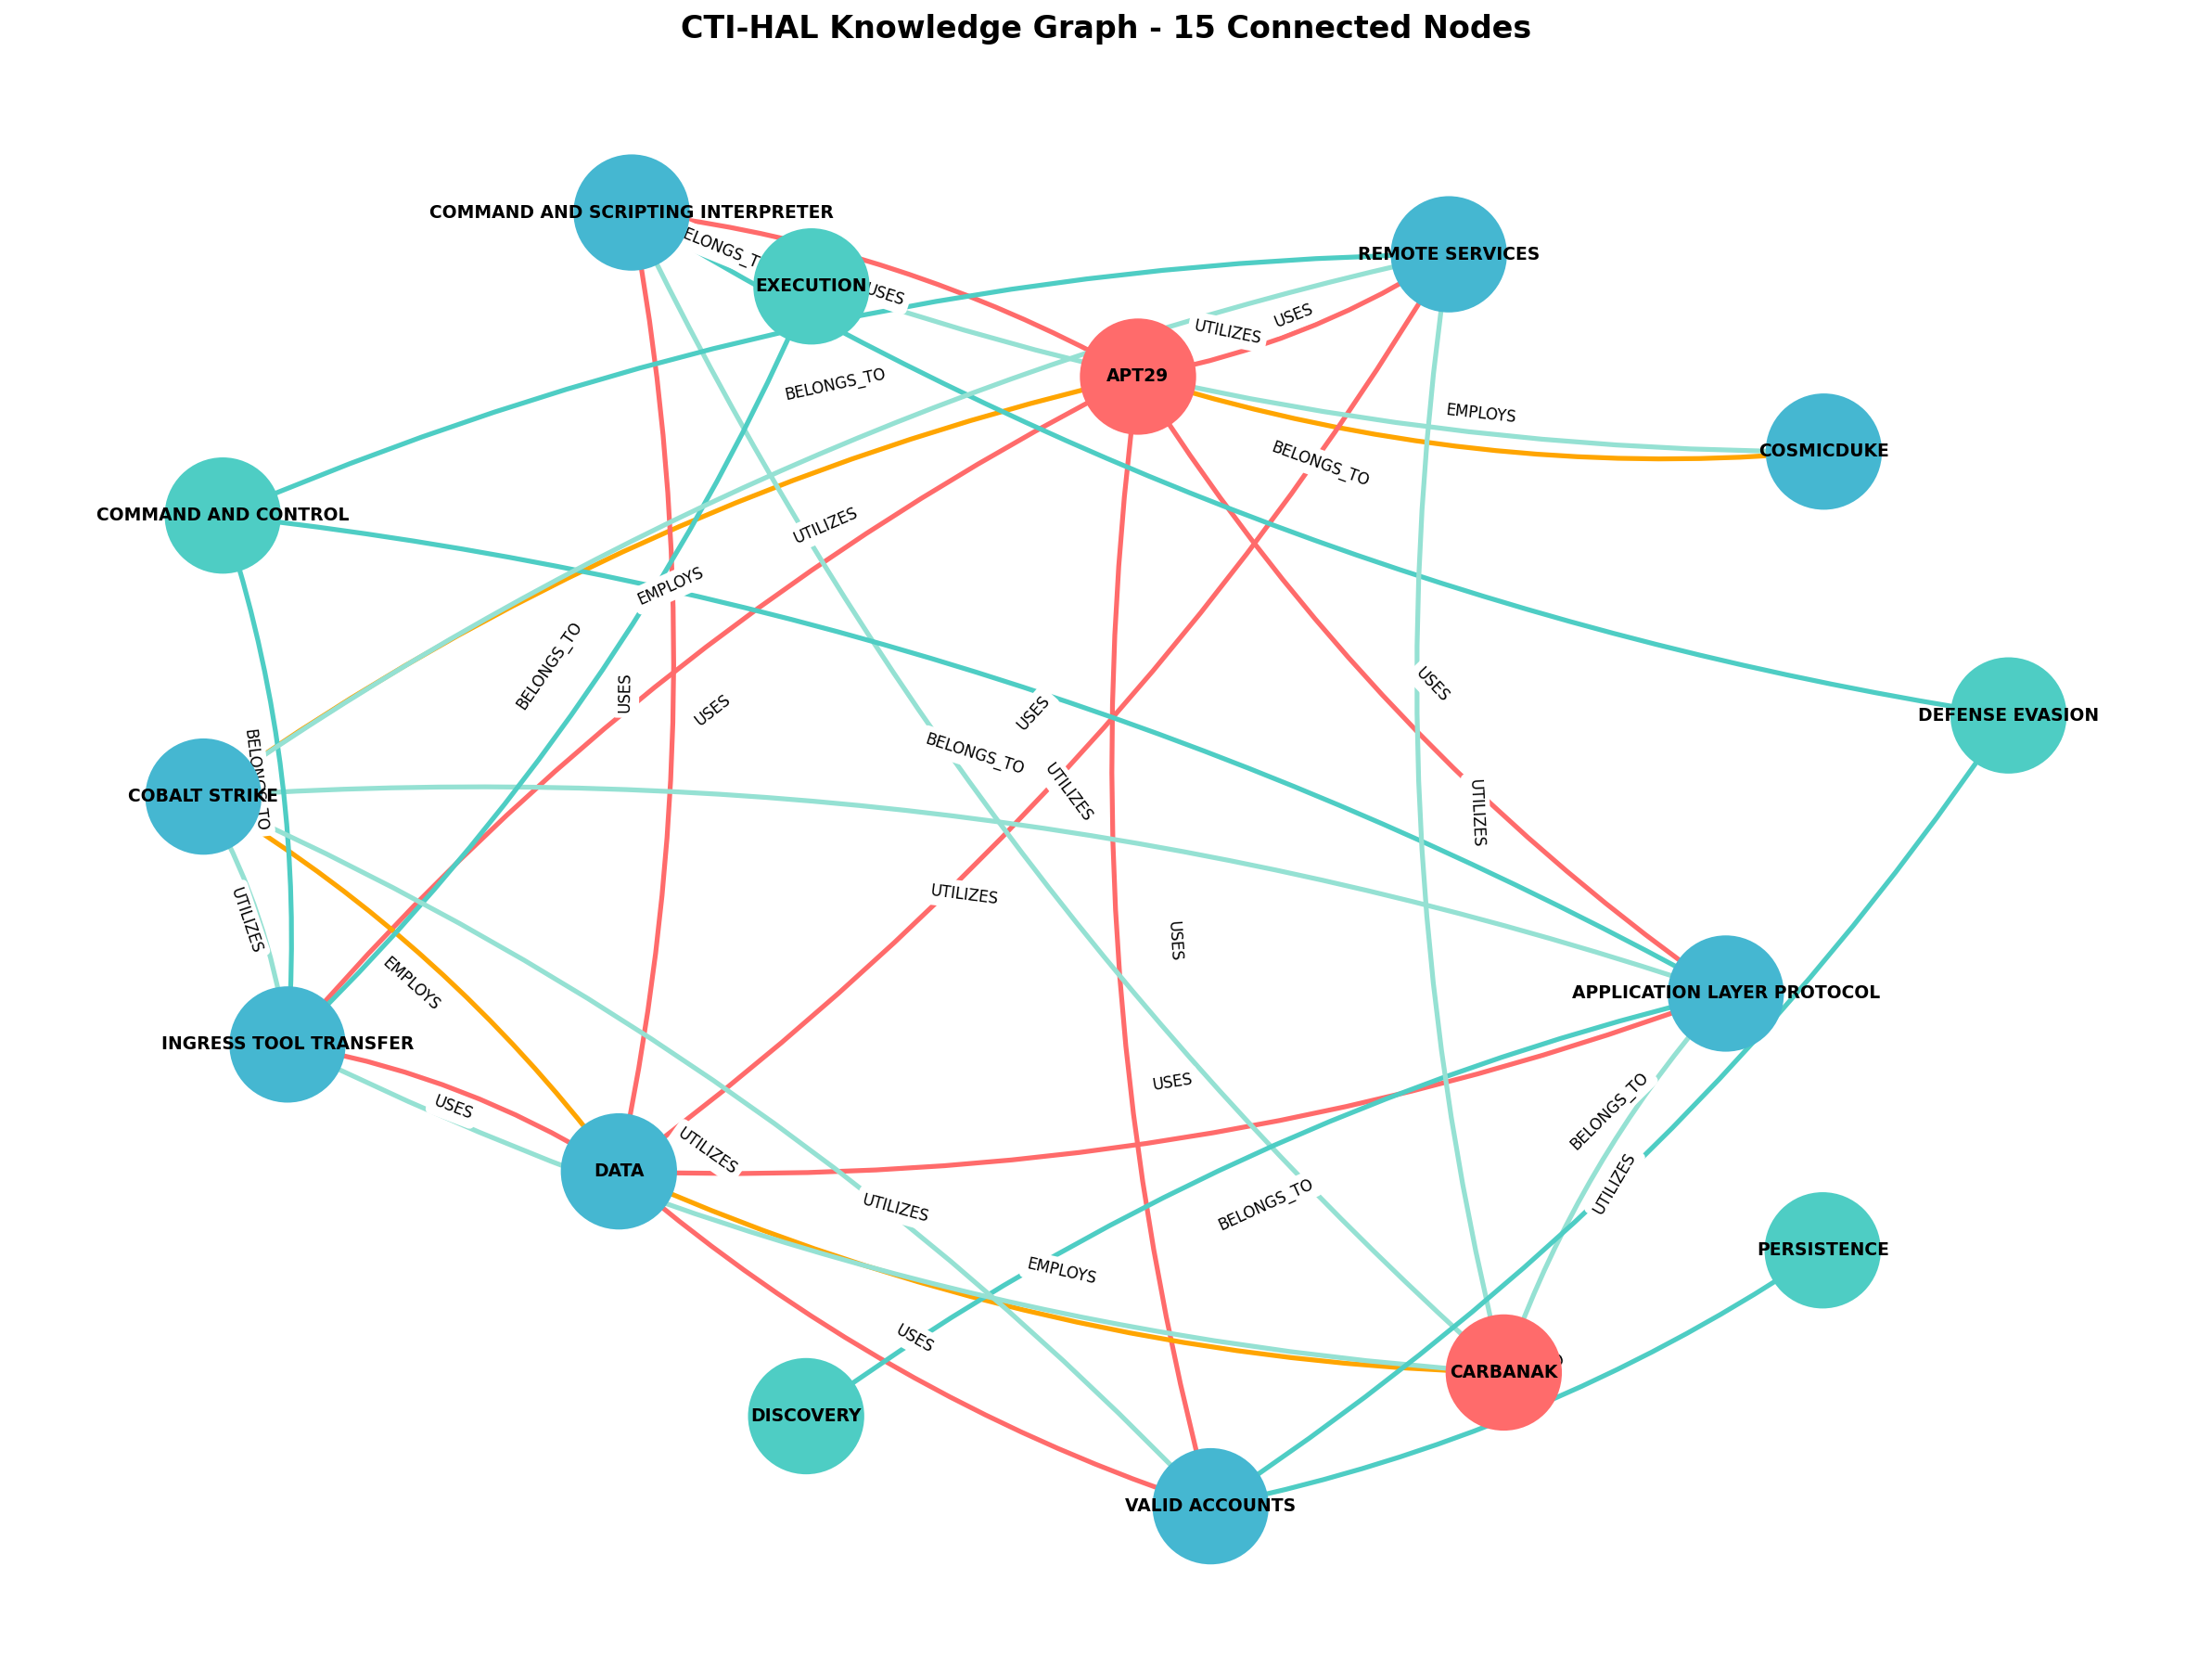


✓ Saved: e:\Knowledge Graph\kg_clean_15_connected_nodes.jpg
  Nodes: 15 | Edges: 32
  Actors: 2
  Tactics: 5
  Techniques/Tools: 8

Creating 25-node Knowledge Graph (Connected Nodes Only)


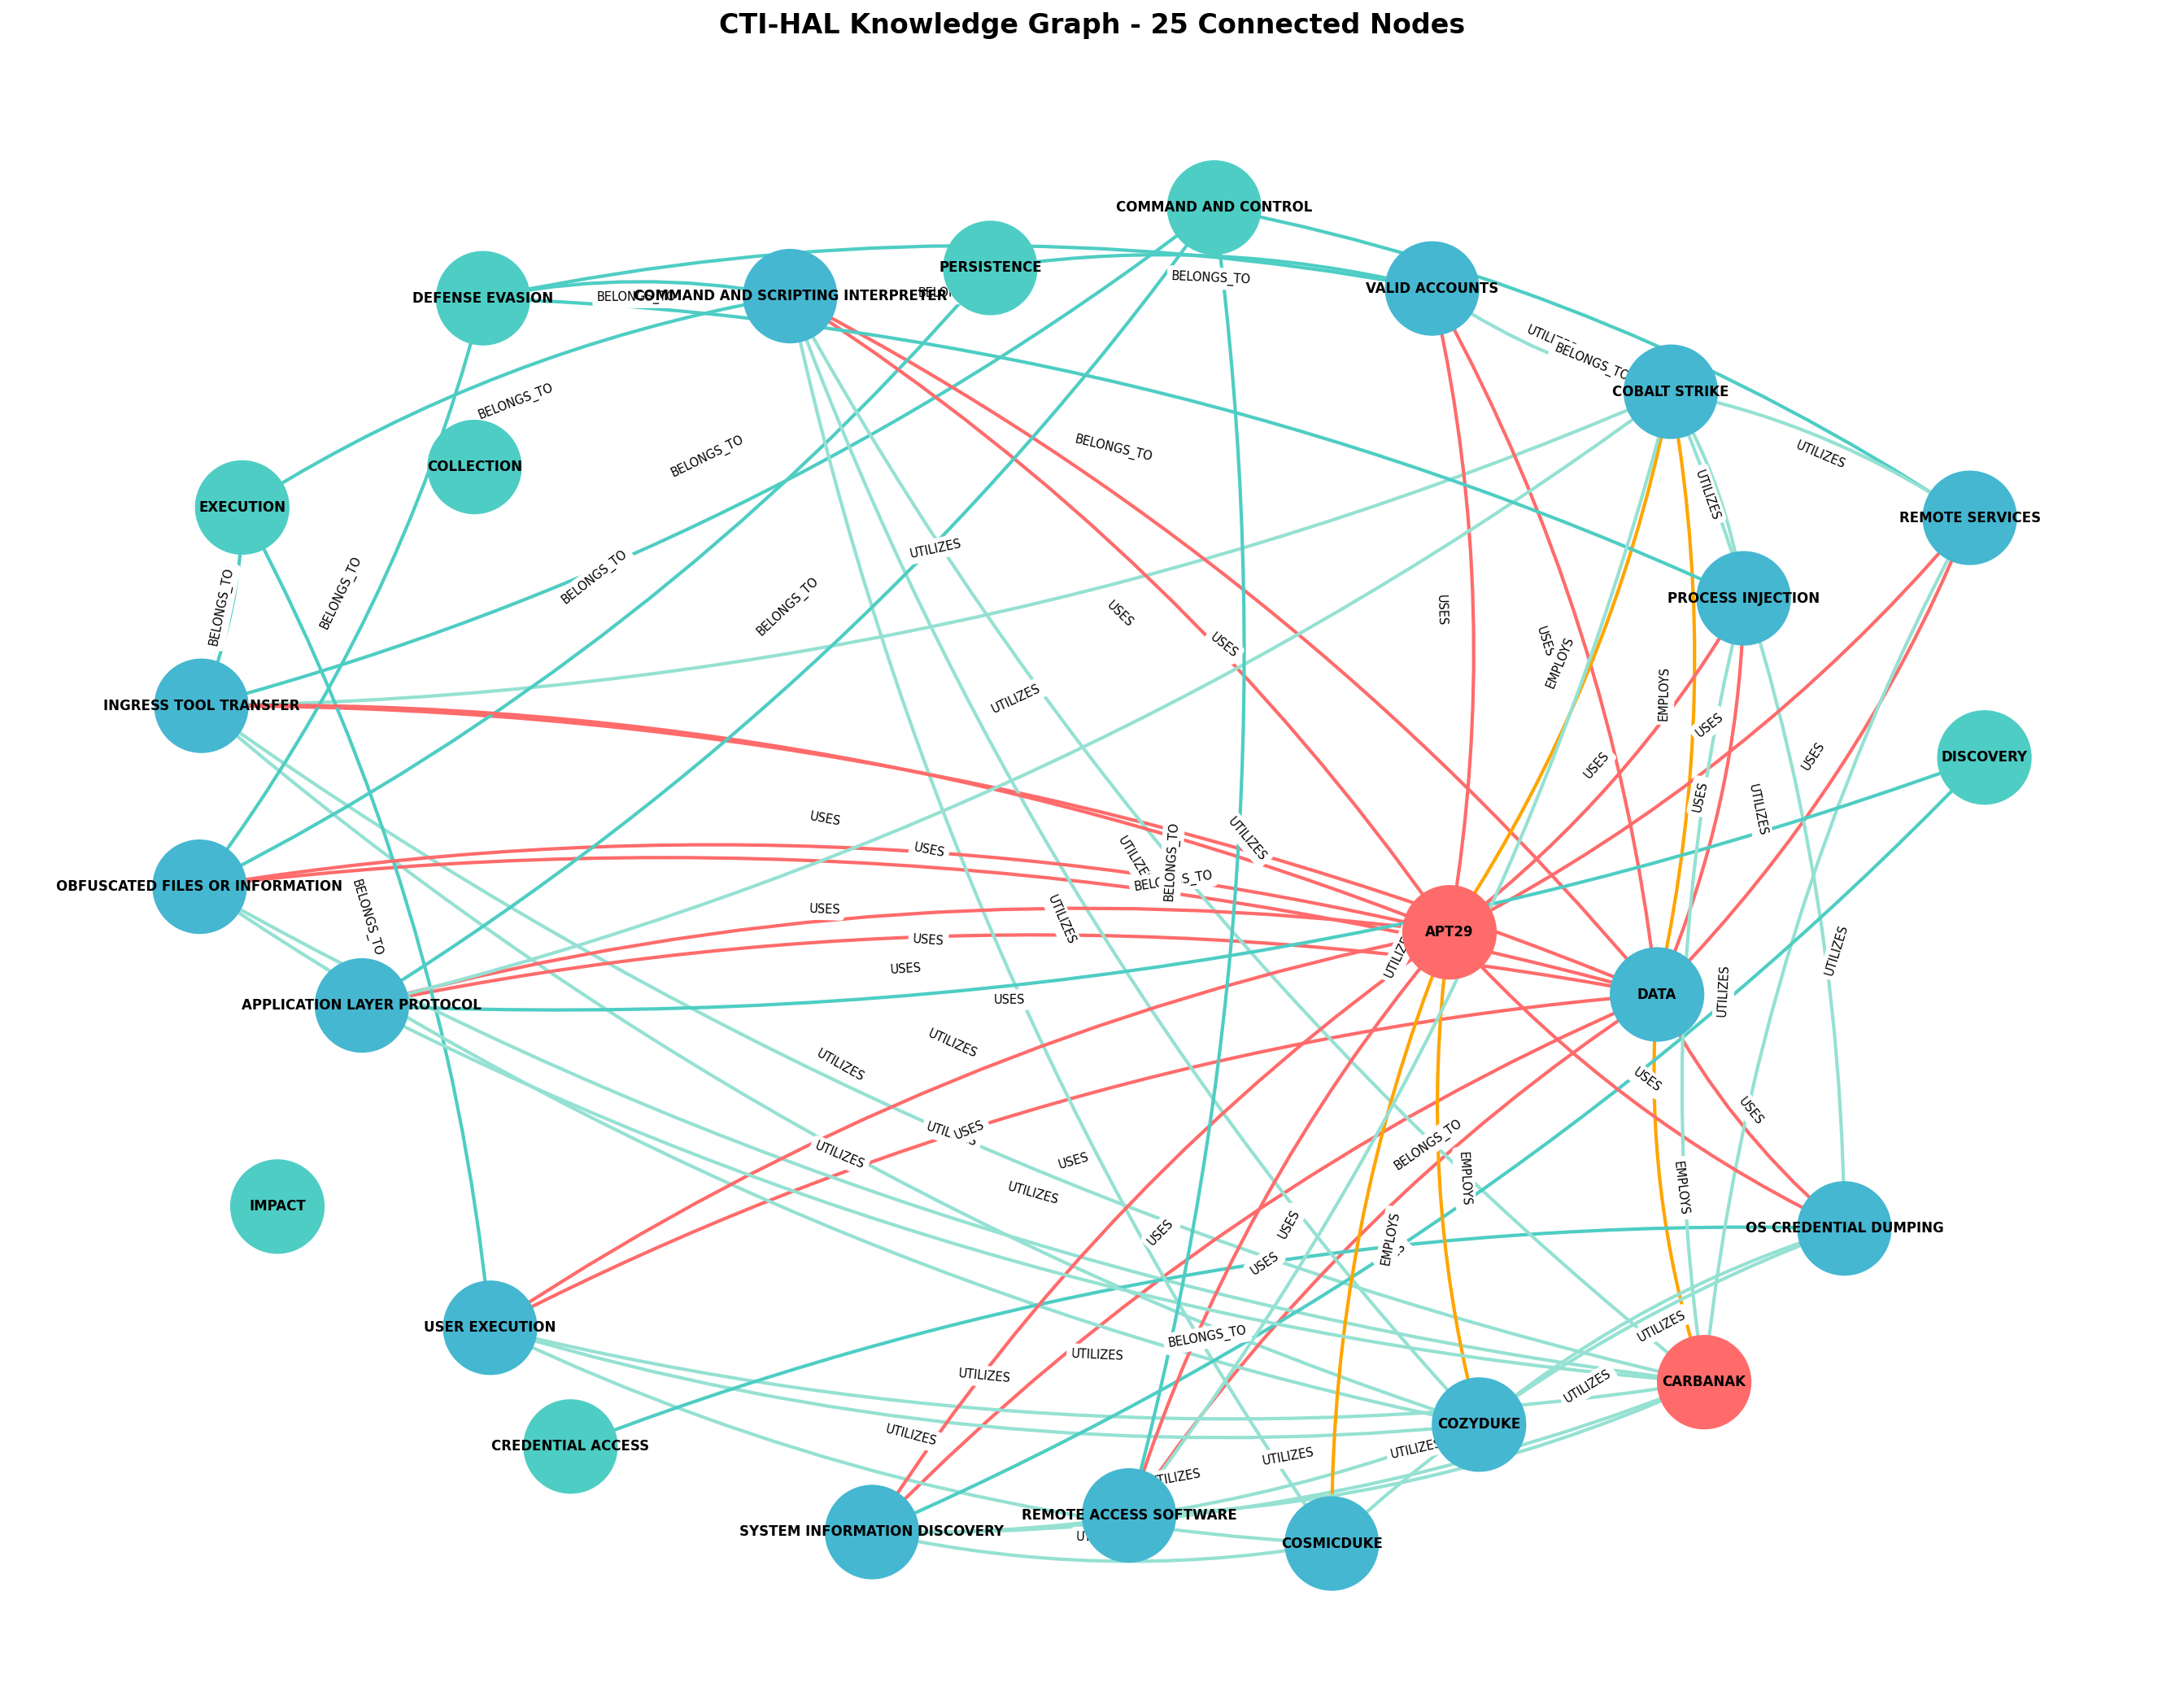


✓ Saved: e:\Knowledge Graph\kg_clean_25_connected_nodes.jpg
  Nodes: 25 | Edges: 69
  Actors: 2
  Tactics: 8
  Techniques/Tools: 15

SUMMARY
Original Knowledge Graph: 300 nodes, 840 edges
Isolated nodes removed: 0

15-node graph: 15 nodes, 32 connections
25-node graph: 25 nodes, 69 connections


In [12]:
# Create clean visualizations with only connected nodes (15 and 25 nodes)

def create_connected_subgraph(graph, num_nodes):
    """
    Create a subgraph with only connected nodes, prioritizing highly connected ones
    """
    # Remove isolated nodes (degree = 0)
    connected_nodes = [n for n in graph.nodes() if graph.degree(n) > 0]
    
    # Calculate degree centrality for all connected nodes
    degree_centrality = {n: graph.degree(n) for n in connected_nodes}
    
    # Sort by degree (number of connections)
    sorted_nodes = sorted(degree_centrality.items(), key=lambda x: x[1], reverse=True)
    
    # Select top nodes
    selected_nodes = [node for node, _ in sorted_nodes[:num_nodes]]
    
    # Create subgraph with only selected nodes
    subgraph = graph.subgraph(selected_nodes).copy()
    
    return subgraph

# Create 15-node visualization
print("=" * 60)
print("Creating 15-node Knowledge Graph (Connected Nodes Only)")
print("=" * 60)

subgraph_15 = create_connected_subgraph(G, 15)

fig, ax = plt.subplots(figsize=(16, 12), dpi=150)
pos_15 = nx.spring_layout(subgraph_15, k=2.5, iterations=50, seed=42)

# Define node colors
node_colors_15 = []
tactics_list = ['RECONNAISSANCE', 'WEAPONIZATION', 'DELIVERY', 'EXPLOITATION', 'INSTALLATION', 
                'COMMAND AND CONTROL', 'ACTIONS ON OBJECTIVES', 'EXECUTION', 'PERSISTENCE', 
                'PRIVILEGE ESCALATION', 'DEFENSE EVASION', 'CREDENTIAL ACCESS', 'DISCOVERY', 
                'LATERAL MOVEMENT', 'COLLECTION', 'EXFILTRATION', 'IMPACT']

for node in subgraph_15.nodes():
    if any(actor in node.upper() for actor in ['APT29', 'FIN7', 'FIN6', 'SANDWORM', 'CARBANAK', 'OILRIG', 'WIZARDSPIDER']):
        node_colors_15.append('#FF6B6B')  # Red for actors
    elif node in tactics_list:
        node_colors_15.append('#4ECDC4')  # Teal for tactics
    else:
        node_colors_15.append('#45B7D1')  # Blue for techniques

# Draw nodes
nx.draw_networkx_nodes(subgraph_15, pos_15, node_color=node_colors_15, node_size=3500, ax=ax)

# Draw edges with colors
edge_colors_15 = []
for u, v in subgraph_15.edges():
    relation = subgraph_15[u][v].get('relation', 'UNKNOWN')
    if relation == 'USES':
        edge_colors_15.append('#FF6B6B')
    elif relation == 'EMPLOYS':
        edge_colors_15.append('#FFA500')
    elif relation == 'BELONGS_TO':
        edge_colors_15.append('#4ECDC4')
    elif relation == 'UTILIZES':
        edge_colors_15.append('#95E1D3')
    else:
        edge_colors_15.append('#999999')

nx.draw_networkx_edges(subgraph_15, pos_15, edge_color=edge_colors_15, width=2.5, 
                       ax=ax, arrows=True, arrowsize=20, arrowstyle='->', 
                       connectionstyle='arc3,rad=0.1')

# Draw labels and edge labels
nx.draw_networkx_labels(subgraph_15, pos_15, font_size=9, font_weight='bold', ax=ax)
edge_labels_15 = {(u, v): subgraph_15[u][v].get('relation', '') for u, v in subgraph_15.edges()}
nx.draw_networkx_edge_labels(subgraph_15, pos_15, edge_labels_15, font_size=8, ax=ax)

ax.set_title('CTI-HAL Knowledge Graph - 15 Connected Nodes', fontsize=16, fontweight='bold', pad=20)
ax.axis('off')
fig.tight_layout()

output_jpg_15 = 'e:\\Knowledge Graph\\kg_clean_15_connected_nodes.jpg'
plt.savefig(output_jpg_15, format='jpg', dpi=150, bbox_inches='tight', facecolor='white')
plt.show()

print(f"\n✓ Saved: {output_jpg_15}")
print(f"  Nodes: {len(subgraph_15.nodes())} | Edges: {len(subgraph_15.edges())}")
print(f"  Actors: {len([n for n in subgraph_15.nodes() if any(actor in n.upper() for actor in ['APT29', 'FIN7', 'FIN6', 'SANDWORM', 'CARBANAK', 'OILRIG', 'WIZARDSPIDER'])])}")
print(f"  Tactics: {len([n for n in subgraph_15.nodes() if n in tactics_list])}")
print(f"  Techniques/Tools: {len([n for n in subgraph_15.nodes() if n not in [actor for actor in ['APT29', 'FIN7', 'FIN6', 'SANDWORM', 'CARBANAK', 'OILRIG', 'WIZARDSPIDER'] if actor in subgraph_15.nodes()] and n not in tactics_list])}")

# Create 25-node visualization
print("\n" + "=" * 60)
print("Creating 25-node Knowledge Graph (Connected Nodes Only)")
print("=" * 60)

subgraph_25 = create_connected_subgraph(G, 25)

fig, ax = plt.subplots(figsize=(18, 14), dpi=150)
pos_25 = nx.spring_layout(subgraph_25, k=2.5, iterations=50, seed=42)

# Define node colors
node_colors_25 = []
for node in subgraph_25.nodes():
    if any(actor in node.upper() for actor in ['APT29', 'FIN7', 'FIN6', 'SANDWORM', 'CARBANAK', 'OILRIG', 'WIZARDSPIDER']):
        node_colors_25.append('#FF6B6B')  # Red for actors
    elif node in tactics_list:
        node_colors_25.append('#4ECDC4')  # Teal for tactics
    else:
        node_colors_25.append('#45B7D1')  # Blue for techniques

# Draw nodes
nx.draw_networkx_nodes(subgraph_25, pos_25, node_color=node_colors_25, node_size=3000, ax=ax)

# Draw edges with colors
edge_colors_25 = []
for u, v in subgraph_25.edges():
    relation = subgraph_25[u][v].get('relation', 'UNKNOWN')
    if relation == 'USES':
        edge_colors_25.append('#FF6B6B')
    elif relation == 'EMPLOYS':
        edge_colors_25.append('#FFA500')
    elif relation == 'BELONGS_TO':
        edge_colors_25.append('#4ECDC4')
    elif relation == 'UTILIZES':
        edge_colors_25.append('#95E1D3')
    else:
        edge_colors_25.append('#999999')

nx.draw_networkx_edges(subgraph_25, pos_25, edge_color=edge_colors_25, width=2.0, 
                       ax=ax, arrows=True, arrowsize=18, arrowstyle='->', 
                       connectionstyle='arc3,rad=0.1')

# Draw labels and edge labels
nx.draw_networkx_labels(subgraph_25, pos_25, font_size=8, font_weight='bold', ax=ax)
edge_labels_25 = {(u, v): subgraph_25[u][v].get('relation', '') for u, v in subgraph_25.edges()}
nx.draw_networkx_edge_labels(subgraph_25, pos_25, edge_labels_25, font_size=7, ax=ax)

ax.set_title('CTI-HAL Knowledge Graph - 25 Connected Nodes', fontsize=16, fontweight='bold', pad=20)
ax.axis('off')
fig.tight_layout()

output_jpg_25 = 'e:\\Knowledge Graph\\kg_clean_25_connected_nodes.jpg'
plt.savefig(output_jpg_25, format='jpg', dpi=150, bbox_inches='tight', facecolor='white')
plt.show()

print(f"\n✓ Saved: {output_jpg_25}")
print(f"  Nodes: {len(subgraph_25.nodes())} | Edges: {len(subgraph_25.edges())}")
print(f"  Actors: {len([n for n in subgraph_25.nodes() if any(actor in n.upper() for actor in ['APT29', 'FIN7', 'FIN6', 'SANDWORM', 'CARBANAK', 'OILRIG', 'WIZARDSPIDER'])])}")
print(f"  Tactics: {len([n for n in subgraph_25.nodes() if n in tactics_list])}")
print(f"  Techniques/Tools: {len([n for n in subgraph_25.nodes() if n not in [actor for actor in ['APT29', 'FIN7', 'FIN6', 'SANDWORM', 'CARBANAK', 'OILRIG', 'WIZARDSPIDER'] if actor in subgraph_25.nodes()] and n not in tactics_list])}")

print("\n" + "=" * 60)
print("SUMMARY")
print("=" * 60)
print(f"Original Knowledge Graph: {G.number_of_nodes()} nodes, {G.number_of_edges()} edges")
print(f"Isolated nodes removed: {len([n for n in G.nodes() if G.degree(n) == 0])}")
print(f"\n15-node graph: {len(subgraph_15.nodes())} nodes, {len(subgraph_15.edges())} connections")
print(f"25-node graph: {len(subgraph_25.nodes())} nodes, {len(subgraph_25.edges())} connections")

In [42]:
# Step 5: Research Analysis (Graph Metrics)
# Compute centralities and identify technique hubs across different APTs
import csv
import math

# Identify actor and tactic node sets
actor_patterns = ['APT', 'FIN', 'CARBANAK', 'OILRIG', 'SANDWORM', 'WIZARDSPIDER']
actors = [n for n in G.nodes() if any(p in n.upper() for p in actor_patterns)]

# Reuse tactics_list defined earlier if present, else define a fallback
try:
    tactics_list
except NameError:
    tactics_list = ['RECONNAISSANCE', 'WEAPONIZATION', 'DELIVERY', 'EXPLOITATION', 'INSTALLATION',
                    'COMMAND AND CONTROL', 'ACTIONS ON OBJECTIVES', 'EXECUTION', 'PERSISTENCE',
                    'PRIVILEGE ESCALATION', 'DEFENSE EVASION', 'CREDENTIAL ACCESS', 'DISCOVERY',
                    'LATERAL MOVEMENT', 'COLLECTION', 'EXFILTRATION', 'IMPACT']

# Classify technique/tool nodes: nodes that are not actors and not tactics
techniques = [n for n in G.nodes() if n not in actors and n not in tactics_list]

# Compute actor coverage per technique: how many distinct actors connect to the technique
tech_actor_counts = []
for tech in techniques:
    connected_actors = set()
    # Check incoming edges where head is actor
    for u, v in G.in_edges(tech):
        if u in actors:
            connected_actors.add(u)
    # Also check outgoing edges where tail is actor (just in case)
    for u, v in G.out_edges(tech):
        if v in actors:
            connected_actors.add(v)
    tech_actor_counts.append({'technique': tech, 'num_actors': len(connected_actors), 'actors': list(connected_actors)})

# Compute degree and betweenness centrality (whole graph)
degree_dict = dict(G.degree())
betweenness = nx.betweenness_centrality(G)

# Merge metrics
metrics = []
for t in tech_actor_counts:
    name = t['technique']
    metrics.append({
        'node': name,
        'num_actors': t['num_actors'],
        'actors': ";".join(t['actors']),
        'degree': degree_dict.get(name, 0),
        'betweenness': betweenness.get(name, 0.0)
    })

# Sort by number of actors (hub across APTs), then degree
metrics_sorted_by_actors = sorted(metrics, key=lambda x: (x['num_actors'], x['degree']), reverse=True)
metrics_sorted_by_degree = sorted(metrics, key=lambda x: x['degree'], reverse=True)
metrics_sorted_by_betweenness = sorted(metrics, key=lambda x: x['betweenness'], reverse=True)

# Save top metrics to CSV files
out_dir = 'e:/Knowledge Graph'
csv_top = os.path.join(out_dir, 'graph_metrics_top_techniques.csv')
csv_full = os.path.join(out_dir, 'graph_metrics_all_techniques.csv')

# Write full metrics
with open(csv_full, 'w', newline='', encoding='utf-8') as f:
    writer = csv.DictWriter(f, fieldnames=['node','num_actors','actors','degree','betweenness'])
    writer.writeheader()
    for row in sorted(metrics, key=lambda x: (x['num_actors'], x['degree']), reverse=True):
        writer.writerow(row)

# Write top 25 by actor coverage
with open(csv_top, 'w', newline='', encoding='utf-8') as f:
    writer = csv.DictWriter(f, fieldnames=['node','num_actors','actors','degree','betweenness'])
    writer.writeheader()
    for row in metrics_sorted_by_actors[:25]:
        writer.writerow(row)

# Print concise summary
print(f"Total techniques/tools analyzed: {len(metrics)}")
print("\nTop techniques by number of distinct APT actors (hub across APTs):")
for i, r in enumerate(metrics_sorted_by_actors[:10], 1):
    print(f"{i}. {r['node']} — {r['num_actors']} actors — degree={r['degree']} — betweenness={r['betweenness']:.4f}")

print("\nTop techniques by degree (most connected overall):")
for i, r in enumerate(metrics_sorted_by_degree[:10], 1):
    print(f"{i}. {r['node']} — degree={r['degree']} — num_actors={r['num_actors']} — betweenness={r['betweenness']:.4f}")

print("\nTop techniques by betweenness centrality:")
for i, r in enumerate(metrics_sorted_by_betweenness[:10], 1):
    print(f"{i}. {r['node']} — betweenness={r['betweenness']:.4f} — degree={r['degree']} — num_actors={r['num_actors']}")

print(f"\nSaved full metrics to: {csv_full}")
print(f"Saved top techniques to: {csv_top}")

# Provide a small pandas preview for interactive use
try:
    import pandas as pd
    df_metrics = pd.DataFrame(metrics_sorted_by_actors)
    display(df_metrics.head(20))
except Exception:
    pass


Total techniques/tools analyzed: 280

Top techniques by number of distinct APT actors (hub across APTs):
1. DATA — 7 actors — degree=228 — betweenness=0.0000
2. COSMICDUKE — 3 actors — degree=18 — betweenness=0.0000
3. COMMAND AND SCRIPTING INTERPRETER — 2 actors — degree=26 — betweenness=0.0001
4. INGRESS TOOL TRANSFER — 2 actors — degree=22 — betweenness=0.0001
5. REMOTE SERVICES — 2 actors — degree=17 — betweenness=0.0001
6. APPLICATION LAYER PROTOCOL — 2 actors — degree=16 — betweenness=0.0000
7. OBFUSCATED FILES OR INFORMATION — 2 actors — degree=14 — betweenness=0.0000
8. PROCESS INJECTION — 2 actors — degree=13 — betweenness=0.0000
9. USER EXECUTION — 2 actors — degree=12 — betweenness=0.0000
10. COZYDUKE — 2 actors — degree=12 — betweenness=0.0000

Top techniques by degree (most connected overall):
1. DATA — degree=228 — num_actors=7 — betweenness=0.0000
2. COMMAND AND SCRIPTING INTERPRETER — degree=26 — num_actors=2 — betweenness=0.0001
3. INGRESS TOOL TRANSFER — degree=22 — n

,node,num_actors,actors,degree,betweenness
0,DATA,7,INPUT CAPTURE;NETWORK SNIFFING;VIDEO CAPTURE;A...,228,0.000000
1,COSMICDUKE,3,SCREEN CAPTURE;APT29;INPUT CAPTURE,18,0.000000
2,COMMAND AND SCRIPTING INTERPRETER,2,APT29;CARBANAK,26,0.000091
3,INGRESS TOOL TRANSFER,2,APT29;CARBANAK,22,0.000114
4,REMOTE SERVICES,2,APT29;CARBANAK,17,0.000083
5,APPLICATION LAYER PROTOCOL,2,APT29;CARBANAK,16,0.000043
6,OBFUSCATED FILES OR INFORMATION,2,APT29;CARBANAK,14,0.000043
7,PROCESS INJECTION,2,APT29;CARBANAK,13,0.000048
8,USER EXECUTION,2,APT29;CARBANAK,12,0.000043
9,COZYDUKE,2,SCREEN CAPTURE;APT29,12,0.000000


In [46]:
# Ensure seaborn is installed
!pip install seaborn -q


[notice] A new release of pip is available: 25.2 -> 26.0
[notice] To update, run: python.exe -m pip install --upgrade pip


C:\Users\sayan\AppData\Local\Temp\ipykernel_25532\3112522413.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='num_actors', y='node', data=top_by_actors, palette='Reds_r')
C:\Users\sayan\AppData\Local\Temp\ipykernel_25532\3112522413.py:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='degree', y='node', data=top_by_degree, palette='Blues_r')
C:\Users\sayan\AppData\Local\Temp\ipykernel_25532\3112522413.py:44: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='betweenness', y='node', data=top_by_betw, palette='Greens_r')


Saved visualizations:
 - e:/Knowledge Graph/top_techniques_by_actors.png
 - e:/Knowledge Graph/top_techniques_by_degree.png
 - e:/Knowledge Graph/top_techniques_by_betweenness.png
 - e:/Knowledge Graph/actor_technique_heatmap.png


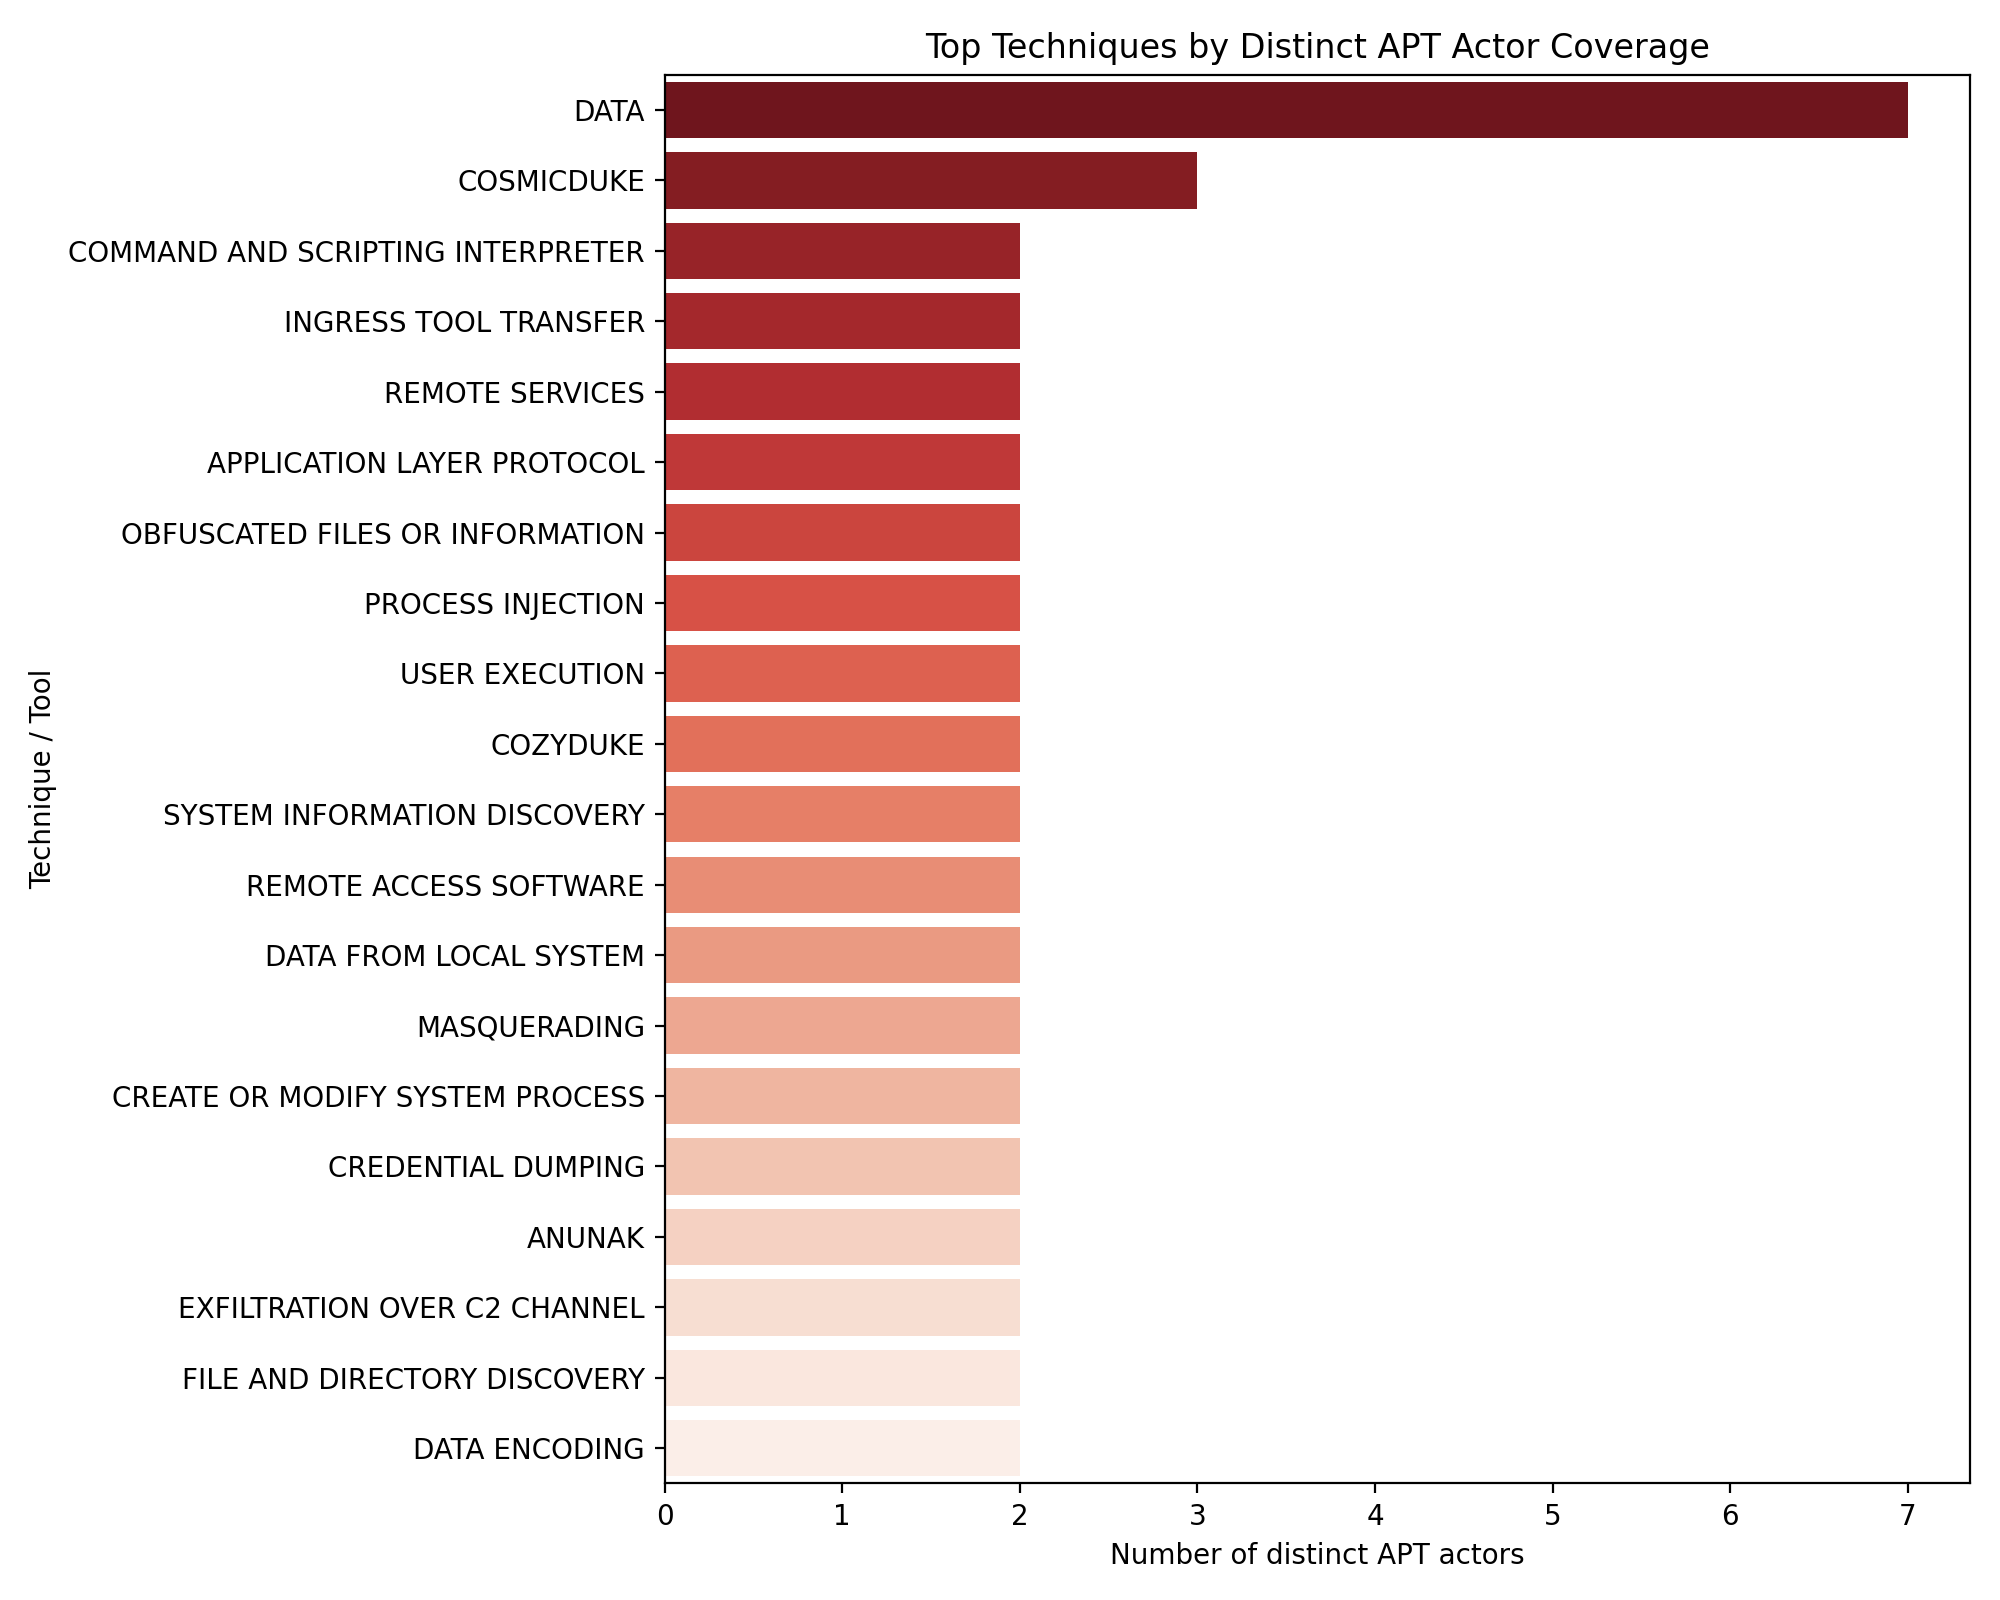

In [47]:
# Visualization: top techniques and actor-technique heatmap
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

csv_top = r'e:/Knowledge Graph/graph_metrics_top_techniques.csv'
csv_full = r'e:/Knowledge Graph/graph_metrics_all_techniques.csv'

# Read metrics
df_top = pd.read_csv(csv_top)
df_all = pd.read_csv(csv_full)

# Ensure numeric types
df_all['degree'] = pd.to_numeric(df_all['degree'], errors='coerce').fillna(0).astype(int)
df_all['betweenness'] = pd.to_numeric(df_all['betweenness'], errors='coerce').fillna(0.0)

# 1) Bar chart: top techniques by number of distinct APT actors
top_by_actors = df_all.sort_values(['num_actors','degree'], ascending=False).head(20)
plt.figure(figsize=(10,8))
sns.barplot(x='num_actors', y='node', data=top_by_actors, palette='Reds_r')
plt.xlabel('Number of distinct APT actors')
plt.ylabel('Technique / Tool')
plt.title('Top Techniques by Distinct APT Actor Coverage')
plt.tight_layout()
output1 = r'e:/Knowledge Graph/top_techniques_by_actors.png'
plt.savefig(output1, dpi=200)
plt.close()

# 2) Bar chart: top techniques by degree
top_by_degree = df_all.sort_values('degree', ascending=False).head(20)
plt.figure(figsize=(10,8))
sns.barplot(x='degree', y='node', data=top_by_degree, palette='Blues_r')
plt.xlabel('Degree (connections)')
plt.ylabel('Technique / Tool')
plt.title('Top Techniques by Degree (Most Connected)')
plt.tight_layout()
output2 = r'e:/Knowledge Graph/top_techniques_by_degree.png'
plt.savefig(output2, dpi=200)
plt.close()

# 3) Bar chart: top techniques by betweenness centrality
top_by_betw = df_all.sort_values('betweenness', ascending=False).head(20)
plt.figure(figsize=(10,8))
sns.barplot(x='betweenness', y='node', data=top_by_betw, palette='Greens_r')
plt.xlabel('Betweenness Centrality')
plt.ylabel('Technique / Tool')
plt.title('Top Techniques by Betweenness Centrality')
plt.tight_layout()
output3 = r'e:/Knowledge Graph/top_techniques_by_betweenness.png'
plt.savefig(output3, dpi=200)
plt.close()

# 4) Actor-Technique heatmap for top techniques (by actor coverage)
# Build actor list from the global `actors` in the notebook if available, else derive from metrics
try:
    actor_list = actors
except NameError:
    # derive actors from graph G if possible
    actor_patterns = ['APT', 'FIN', 'CARBANAK', 'OILRIG', 'SANDWORM', 'WIZARDSPIDER']
    actor_list = [n for n in G.nodes() if any(p in n.upper() for p in actor_patterns)]

# Choose top N techniques for heatmap
N = 20
selected_techs = top_by_actors['node'].head(N).tolist()

# Build presence matrix: rows=techniques, cols=actors
presence = pd.DataFrame(0, index=selected_techs, columns=actor_list)
for idx, row in df_all.iterrows():
    tech = row['node']
    if tech not in selected_techs:
        continue
    actor_str = str(row.get('actors',''))
    if pd.isna(actor_str) or actor_str == '':
        continue
    for a in actor_str.split(';'):
        a = a.strip()
        if a in presence.columns:
            presence.at[tech, a] = 1

# If actor list is long, reduce columns to actors that appear in presence
presence = presence.loc[:, (presence.sum(axis=0) > 0)]

plt.figure(figsize=(12, max(4, 0.4*len(selected_techs))))
sns.heatmap(presence, cmap='YlOrRd', cbar_kws={'label':'Actor uses technique (1=yes)'}, linewidths=0.5, linecolor='gray')
plt.xlabel('APT Actors')
plt.ylabel('Techniques / Tools')
plt.title('Actor - Technique Presence (Top Techniques)')
plt.tight_layout()
output4 = r'e:/Knowledge Graph/actor_technique_heatmap.png'
plt.savefig(output4, dpi=200)
plt.close()

print('Saved visualizations:')
print(f' - {output1}')
print(f' - {output2}')
print(f' - {output3}')
print(f' - {output4}')

# Display small preview if running interactively
try:
    from IPython.display import Image, display
    display(Image(output1, width=600))
except Exception:
    pass


In [55]:
# Install and test google.generativeai
import sys
import subprocess

try:
    import google.generativeai as genai
    print('google.generativeai is already installed.')
except ModuleNotFoundError:
    print('google.generativeai not found — installing via pip...')
    try:
        subprocess.check_call([sys.executable, '-m', 'pip', 'install', 'google-generativeai'])
        import importlib
        importlib.invalidate_caches()
        import google.generativeai as genai
        print('Installed and imported google.generativeai successfully.')
    except Exception as e:
        print('Failed to install or import google.generativeai:')
        print(e)
        print('\nNext steps:')
        print(" - Ensure you have network access from this environment.")
        print(" - If installation fails, you can call Google GenAI REST endpoints directly (use `requests`) or run this notebook in an environment with internet access and pip.")
        print(" - See https://developers.generativeai.google for setup and API key instructions.")

# Quick import check
try:
    import google.generativeai as genai
    print('\nModule import check: OK')
except Exception as e:
    print('\nModule import check: FAILED')
    print(e)


google.generativeai is already installed.

Module import check: OK


In [ ]:
# Secure Gemini initialization (no hardcoded API keys)
# Installs the client and configures the model using an env var or secure prompt.
!pip install -q -U google-generativeai

import os
import getpass
import google.generativeai as genai

# Prefer environment variable (useful in Colab: set via os.environ or colab secrets)
api_key = os.environ.get('GEMINI_API_KEY')
if not api_key:
    api_key = getpass.getpass('Enter your Gemini API key (input hidden): ')

if not api_key:
    raise RuntimeError('No API key provided. Set GEMINI_API_KEY or input your key when prompted.')

genai.configure(api_key=api_key)
model = genai.GenerativeModel('gemini-1.5-pro')
print('Gemini model configured (API key not stored in notebook).')



[notice] A new release of pip is available: 25.2 -> 26.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [ ]:
# Prompt template and helper functions for extracting CTI triples with robust few-shot examples
import time
import re

# Allowed relation vocabulary (model should use only these)
ALLOWED_RELATIONS = ['USES','BELONGS_TO','UTILIZES','EMPLOYS','TARGETS','C2_OF','COMMUNICATES_WITH','EXPLOITS']

FEW_SHOT_EXAMPLES = '''
# Examples (one triple per line, exact format: Subject | Relationship | Object)
APT29 | USES | INGRESS TOOL TRANSFER
INGRESS TOOL TRANSFER | BELONGS_TO | EXECUTION
COSMICDUKE | UTILIZES | COMMAND AND SCRIPTING INTERPRETER
COZYDUKE | C2_OF | 198.51.100.23
SPEARPHISHING | DELIVERS | COBALT STRIKE
COBALT STRIKE | EMPLOYS | REMOTE SERVICES
CVE-2021-34527 | EXPLOITS | PRINTSPOOLER
BANKING_INSTITUTION | TARGETS | FINANCIAL SECTOR
'''

PROMPT_TEMPLATE = '''
You are a Cybersecurity Research Assistant. Extract concise Knowledge Graph triples from the provided CTI text.

Requirements (READ CAREFULLY):
- Output ONLY triples, one per line, using this exact delimiter: space-pipe-space (" | ").
- Each triple must use a relation from this allowed set: {allowed_relations}
- Subjects and Objects should be short canonical phrases. Prefer uppercase for technique/tool/tactic names (e.g., "INGRESS TOOL TRANSFER").
- If the text mentions an IP, domain, or C2, include it literally (e.g., "198.51.100.23" or "mal.example.com").
- Do NOT invent entities or relations. If you are uncertain, omit the triple.
- If NO valid triples exist, output exactly: NO_TRIPLES
- Do NOT provide any surrounding commentary, numbering, or explanation.

Few-shot examples (do not repeat the explanatory comments):
{few_shot}

Text:
"""
{text}
"""

Triples:
'''.format(allowed_relations=', '.join(ALLOWED_RELATIONS), few_shot=FEW_SHOT_EXAMPLES, text='{text}')

# Parse LLM response lines into triples
TRIPLE_LINE_RE = re.compile(r'^(.+?)\s\|\s([A-Z_]+)\s\|\s(.+)$')

def parse_triples_from_response(resp_text):
    resp_text = resp_text.strip()
    if not resp_text:
        return []
    # Handle explicit NO_TRIPLES response
    if resp_text.strip() == 'NO_TRIPLES':
        return []

    triples = []
    for line in resp_text.splitlines():
        line = line.strip()
        if not line:
            continue
        m = TRIPLE_LINE_RE.match(line)
        if not m:
            # Skip lines that don't match strict format
            continue
        subj, rel, obj = m.group(1).strip(), m.group(2).strip(), m.group(3).strip()
        # Only accept allowed relations
        if rel not in ALLOWED_RELATIONS:
            continue
        triples.append({'head': subj, 'relation': rel, 'tail': obj})
    return triples

# Wrapper that calls the Gemini model with retries and simple backoff
def extract_triples_from_text(text, max_retries=3, wait_seconds=2):
    prompt = PROMPT_TEMPLATE.format(text=text)
    last_exc = None
    for attempt in range(max_retries):
        try:
            resp = model.generate_content(prompt)
            # `resp` may have .text or .content; handle accordingly
            text_out = getattr(resp, 'text', None) or getattr(resp, 'content', None) or str(resp)
            parsed = parse_triples_from_response(text_out)
            return parsed, text_out
        except Exception as e:
            last_exc = e
            time.sleep(wait_seconds * (attempt + 1))
    raise RuntimeError('LLM extraction failed') from last_exc


In [ ]:
# Batch extraction runner: apply the LLM extractor to DESCRIPTION and NOTES fields
import csv
from tqdm import tqdm

llm_triples = []

# We'll process entries across files (use the already-loaded `data` if present, otherwise iterate files)
# To save time/tokens, process in batches and optionally limit number of entries (set LIMIT=None to run all)
LIMIT = None  # change to an int during experimentation, e.g., 200

def process_dataset_entries(limit=LIMIT):
    processed = 0
    # If `data` is in scope (most-recent opened file), use it; otherwise iterate over files
    if 'data' in globals() and isinstance(data, list):
        # single-file dataset
        iterator = ((None, e) for e in data)
    else:
        # iterate all files and load JSON entries
        def gen_entries():
            for fp in files:
                try:
                    with open(fp, 'r', encoding='utf-8') as fh:
                        j = json.load(fh)
                        for entry in j:
                            yield (fp, entry)
                except Exception:
                    continue
        iterator = gen_entries()

    for fp, entry in tqdm(iterator):
        if limit and processed >= limit:
            break
        # Merge DESCRIPTION and NOTES
        text_parts = []
        for k in ['DESCRIPTION', 'DESCRIPTION_TEXT', 'NOTES', 'context', 'note']:
            val = entry.get(k) if isinstance(entry, dict) else None
            if not val and isinstance(entry, dict):
                # sometimes keys are lowercase
                val = entry.get(k.lower())
            if val:
                text_parts.append(str(val))
        text = '\n'.join(text_parts).strip()
        if not text:
            continue
        try:
            parsed_triples, raw = extract_triples_from_text(text)
        except Exception as e:
            # log and continue
            print(f'Extraction failed for entry in {fp}: {e}')
            continue
        for t in parsed_triples:
            t['source_file'] = fp
            t['source'] = 'LLM_Extraction'
            t['raw_response'] = raw
            llm_triples.append(t)
        processed += 1
    return llm_triples

# Run extraction (careful with limits; starts with small sample)
sample_limit = 100  # adjust as needed; set to None to run entire dataset
extracted = process_dataset_entries(limit=sample_limit)

# Save extracted triples
out_llm_csv = r'e:/Knowledge Graph/llm_extracted_triples_sample.csv'
with open(out_llm_csv, 'w', newline='', encoding='utf-8') as f:
    writer = csv.DictWriter(f, fieldnames=['head','relation','tail','source','source_file','raw_response'])
    writer.writeheader()
    for row in extracted:
        writer.writerow(row)

print(f'Saved {len(extracted)} LLM-extracted triples to: {out_llm_csv}')

# Merge with existing df_kg (if present)
try:
    df_llm = pd.DataFrame(extracted)
    if 'df_kg' in globals():
        final_kg_df = pd.concat([df_kg, df_llm], ignore_index=True).drop_duplicates()
        final_out_csv = r'e:/Knowledge Graph/final_kg_with_llm.csv'
        final_kg_df.to_csv(final_out_csv, index=False)
        print(f'Merged KG saved to: {final_out_csv} (total rows: {len(final_kg_df)})')
    else:
        print('df_kg not found in workspace; saved LLM triples only.')
except Exception as e:
    print('Failed to merge LLM triples into df_kg:', e)


In [59]:
# Combine your previous 'df_kg' with the new 'df_llm'
final_kg_df = pd.concat([df_kg, df_llm], ignore_index=True)

# Visualize with distinct colors for LLM nodes vs. MITRE nodes
G = nx.MultiDiGraph()
for _, row in final_kg_df.iterrows():
    color = "skyblue" if row.get('source') != 'LLM_Extraction' else "orange"
    G.add_node(row['head'], color=color)
    G.add_node(row['tail'], color=color)
    G.add_edge(row['head'], row['tail'], label=row['relation'])

# Display the Graph
net = Network(height='700px', width='100%', bgcolor='#eeeeee', notebook=True)
net.from_nx(G)
net.show("enhanced_cti_kg.html")

enhanced_cti_kg.html


In [60]:
# Identify potential starting tactics (Reconnaissance / Initial Access)
start_tactics = [n for n, d in G.nodes(data=True) if "Initial Access" in str(n)]

# Identify goal tactics (Exfiltration / Impact)
end_tactics = [n for n, d in G.nodes(data=True) if "Exfiltration" in str(n) or "Impact" in str(n)]

print(f"Searching for paths from {len(start_tactics)} entry points to {len(end_tactics)} objectives.")

Searching for paths from 0 entry points to 0 objectives.


In [62]:
import networkx as nx

all_detected_chains = []

for start in start_tactics:
    for end in end_tactics:
        try:
            # We limit 'cutoff' to 5 or 6 to avoid 'path explosion' in dense graphs
            paths = nx.all_simple_paths(G, source=start, target=end, cutoff=5)
            all_detected_chains.extend(list(paths))
        except nx.NetworkXNoPath:
            continue

print(f"Successfully identified {len(all_detected_chains)} potential attack chains.")

Successfully identified 0 potential attack chains.


In [63]:
if all_detected_chains:
    sample_chain = all_detected_chains[0]
    print(f"Sample Chain Detected: {' -> '.join(sample_chain)}")
    
    # Create a subgraph for just this chain to visualize clearly
    path_edges = list(zip(sample_chain, sample_chain[1:]))
    path_graph = G.edge_subgraph(path_edges).copy()
    
    # Visualize the chain
    nt = Network(height='400px', width='100%', notebook=True, directed=True)
    nt.from_nx(path_graph)
    nt.show("attack_chain_demo.html")

### 15-node visualization (no node labels)
This cell draws the 15-node connected subgraph hiding node names, preserving edge labels, and adds a color legend. It saves the figure to `e:/Knowledge Graph/kg_clean_15_connected_nodes_nolabels.jpg`.

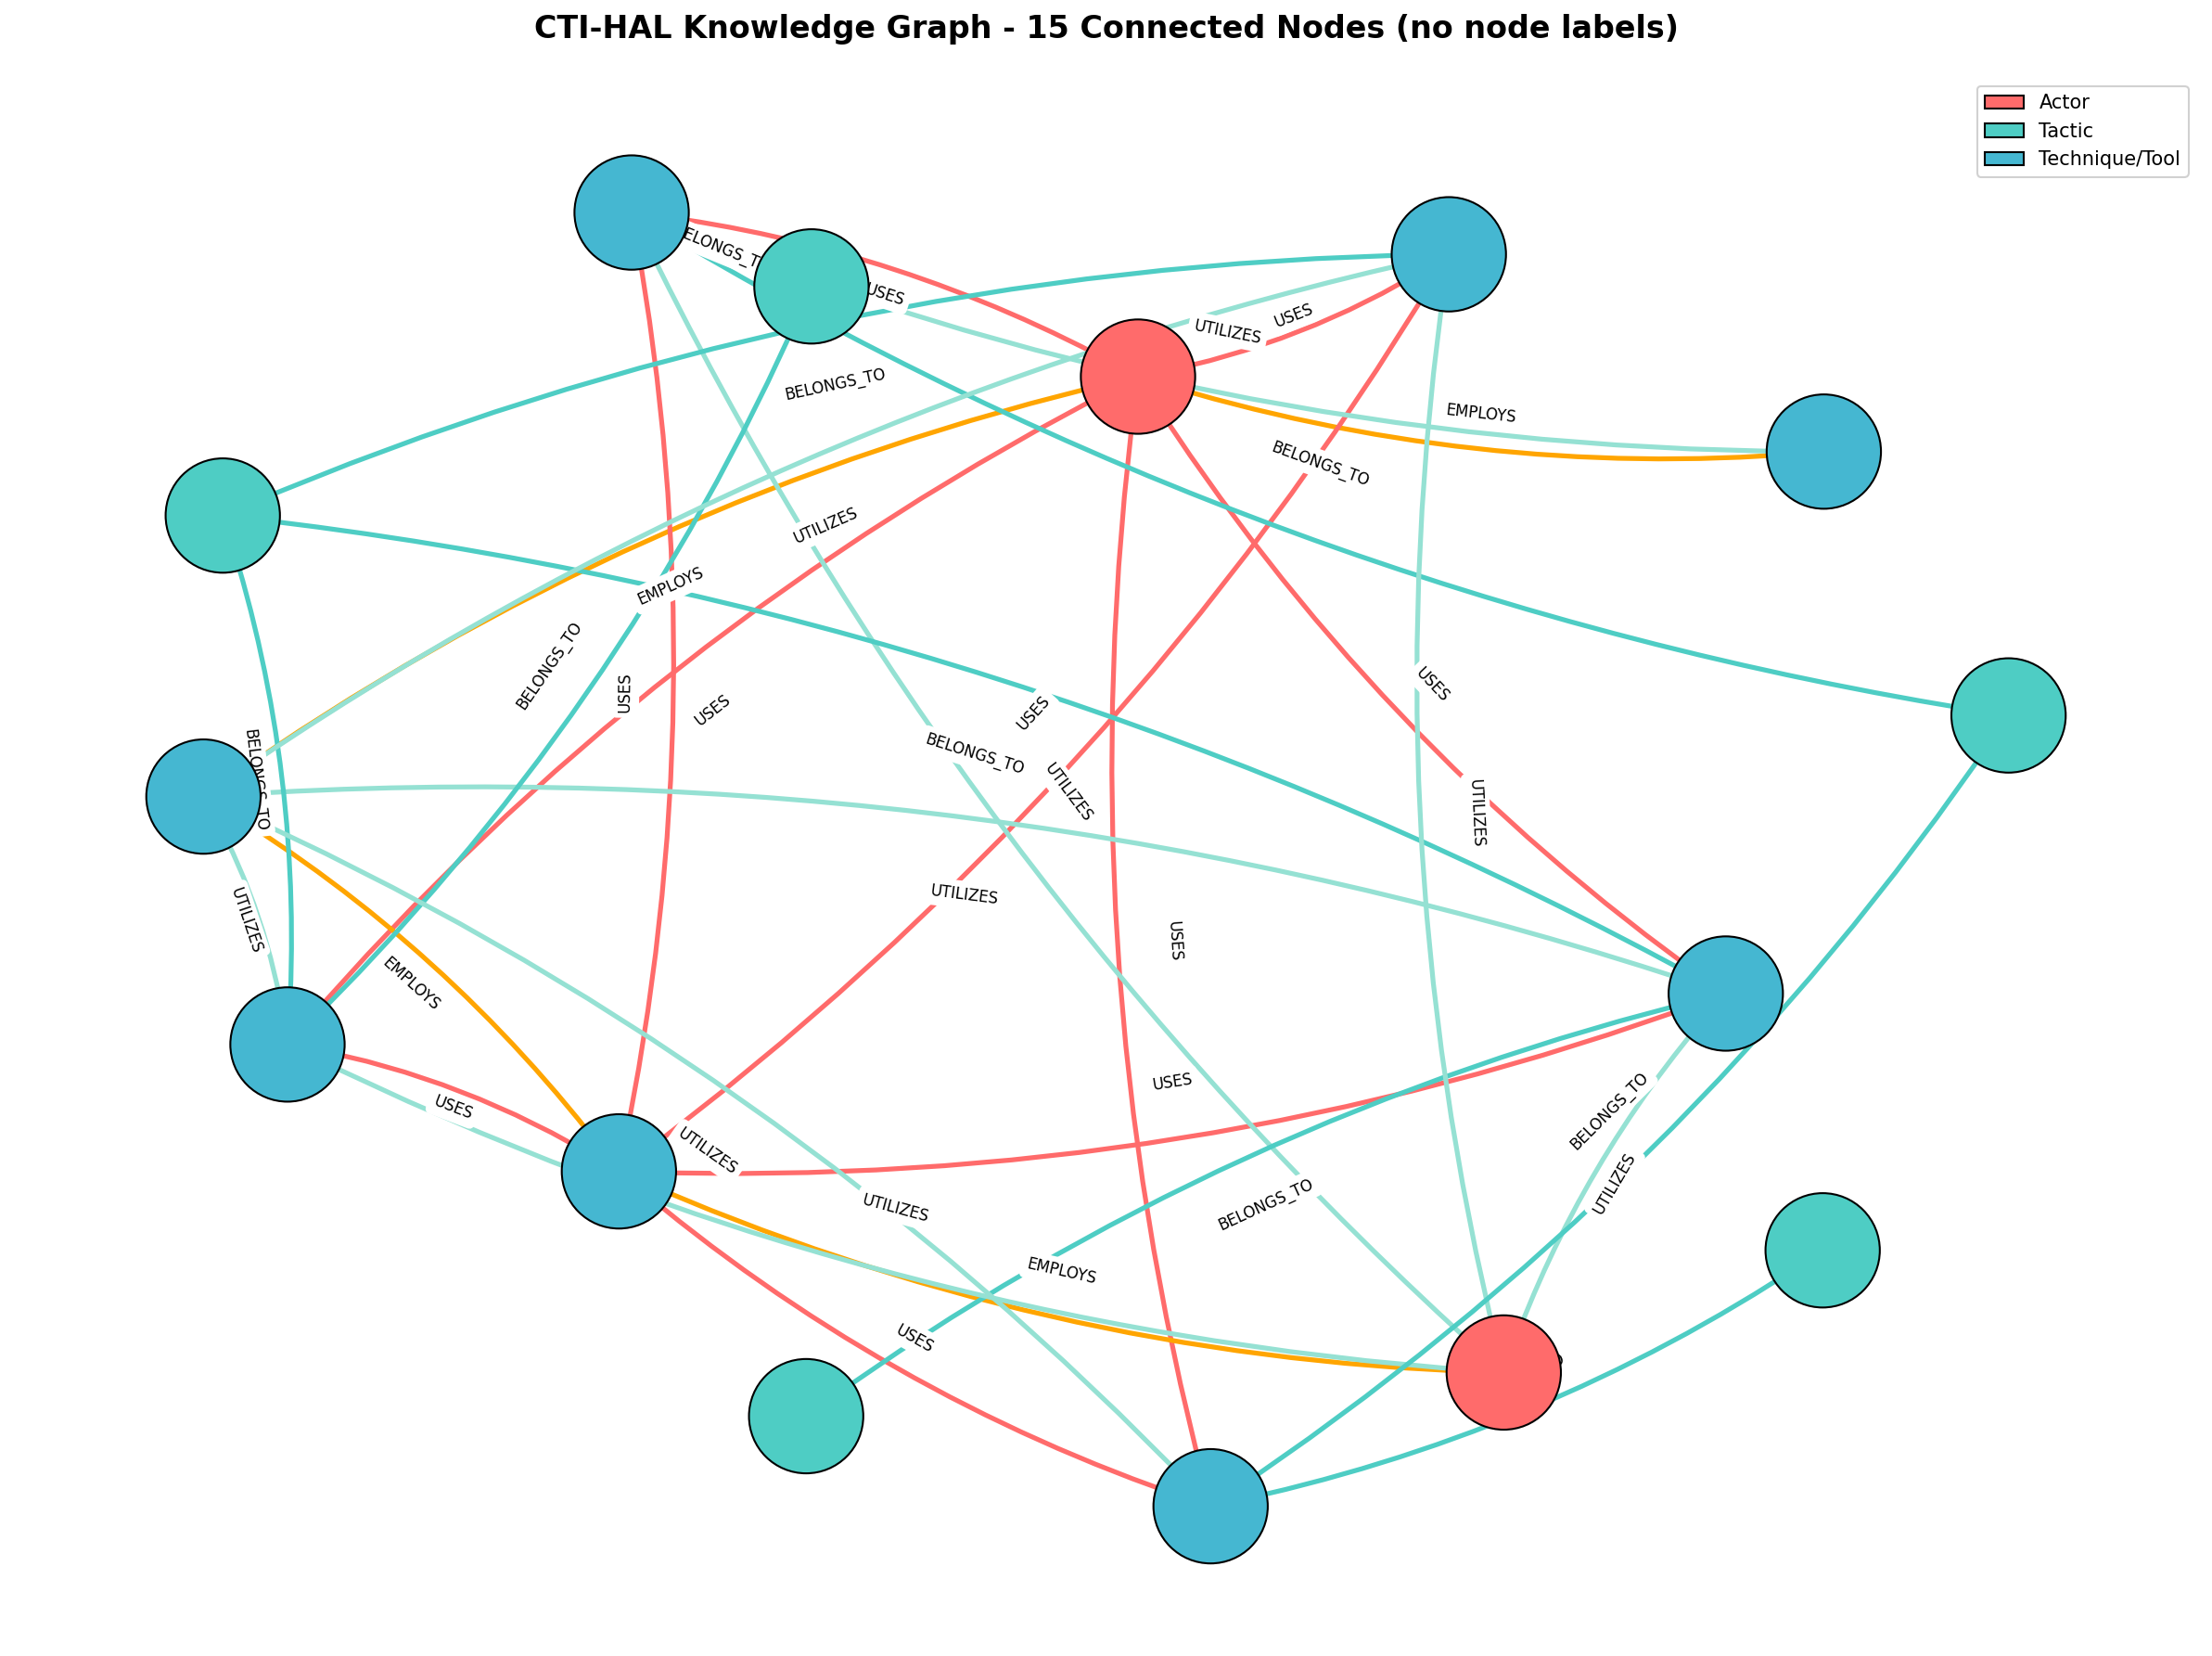


✓ Saved: e:/Knowledge Graph/kg_clean_15_connected_nodes_nolabels.jpg
  Nodes: 15 | Edges: 32


In [13]:
# Draw 15-node subgraph without node labels, keep edge labels, add legend
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import networkx as nx

# Ensure the 15-node subgraph exists; prefer `create_connected_subgraph`, else build from `G`
if 'subgraph_15' not in globals():
    if 'create_connected_subgraph' in globals():
        subgraph_15 = create_connected_subgraph(G, 15)
    elif 'G' in globals():
        # Build a connected subgraph by selecting top-degree connected nodes
        connected_nodes = [n for n in G.nodes() if G.degree(n) > 0]
        degree_sorted = sorted(connected_nodes, key=lambda n: G.degree(n), reverse=True)
        selected = degree_sorted[:15]
        subgraph_15 = G.subgraph(selected).copy()
    else:
        raise RuntimeError('`G` is not defined. Run earlier cells first.')

# Compute layout if not present
if 'pos_15' not in globals():
    pos_15 = nx.spring_layout(subgraph_15, k=2.5, iterations=50, seed=42)

fig, ax = plt.subplots(figsize=(16, 12), dpi=150)

# Tactics fallback list if not defined
try:
    tactics_list
except NameError:
    tactics_list = ['RECONNAISSANCE','WEAPONIZATION','DELIVERY','EXPLOITATION','INSTALLATION',
                    'COMMAND AND CONTROL','ACTIONS ON OBJECTIVES','EXECUTION','PERSISTENCE',
                    'PRIVILEGE ESCALATION','DEFENSE EVASION','CREDENTIAL ACCESS','DISCOVERY',
                    'LATERAL MOVEMENT','COLLECTION','EXFILTRATION','IMPACT']

# Define actor heuristics
actors_heurst = ['APT29','APT','FIN7','FIN6','SANDWORM','CARBANAK','OILRIG','WIZARDSPIDER']

# Node colors by type (no labels drawn)
node_colors = []
for node in subgraph_15.nodes():
    if any(a in node.upper() for a in actors_heurst):
        node_colors.append('#FF6B6B')
    elif node in tactics_list:
        node_colors.append('#4ECDC4')
    else:
        node_colors.append('#45B7D1')

# Draw nodes (no text labels)
nx.draw_networkx_nodes(subgraph_15, pos_15, node_color=node_colors, node_size=3500, ax=ax, linewidths=1, edgecolors='k')

# Draw edges with color mapping by relation
edge_colors = []
for u, v in subgraph_15.edges():
    rel = subgraph_15[u][v].get('relation', '').upper()
    if rel == 'USES':
        edge_colors.append('#FF6B6B')
    elif rel == 'EMPLOYS':
        edge_colors.append('#FFA500')
    elif rel == 'BELONGS_TO':
        edge_colors.append('#4ECDC4')
    elif rel == 'UTILIZES':
        edge_colors.append('#95E1D3')
    else:
        edge_colors.append('#999999')

nx.draw_networkx_edges(subgraph_15, pos_15, edge_color=edge_colors, width=2.5, ax=ax, arrows=True, arrowsize=20, arrowstyle='->', connectionstyle='arc3,rad=0.1')

# Do NOT draw node text labels (hide names)
# nx.draw_networkx_labels(subgraph_15, pos_15, font_size=9, font_weight='bold', ax=ax)  # intentionally omitted

# Draw edge labels (relations)
edge_labels = {(u, v): subgraph_15[u][v].get('relation', '') for u, v in subgraph_15.edges()}
nx.draw_networkx_edge_labels(subgraph_15, pos_15, edge_labels=edge_labels, font_size=8, ax=ax)

# Add legend mapping node-type colors
legend_handles = [
    Patch(facecolor='#FF6B6B', edgecolor='k', label='Actor'),
    Patch(facecolor='#4ECDC4', edgecolor='k', label='Tactic'),
    Patch(facecolor='#45B7D1', edgecolor='k', label='Technique/Tool'),
]
ax.legend(handles=legend_handles, loc='upper right', framealpha=0.9)

ax.set_title('CTI-HAL Knowledge Graph - 15 Connected Nodes (no node labels)', fontsize=16, fontweight='bold', pad=20)
ax.axis('off')
fig.tight_layout()

output_jpg_15_nolabels = 'e:/Knowledge Graph/kg_clean_15_connected_nodes_nolabels.jpg'
plt.savefig(output_jpg_15_nolabels, format='jpg', dpi=150, bbox_inches='tight', facecolor='white')
plt.show()

print(f"\n✓ Saved: {output_jpg_15_nolabels}")
print(f"  Nodes: {len(subgraph_15.nodes())} | Edges: {len(subgraph_15.edges())}")